## Description des données

Ce jeu de données a été rendu disponible par l'entreprise brésilienne Olist Store. Il renferme des informations sur 100000 commandes effectuées entre 2016 et 2018 au niveau de divers marché au Brésil. Il s'agit de données commerciales réelles anonymisées et les références aux entreprises et partenaires ont été remplacé par du texte de Game of Thrones. Il contient des informations sur les clients et leur localisation. Il peut être utilisé pour identifier les clients dans l'ensemble des commandes ainsi que leur livraison.</br> 

Dans ce notebook nous allons procéder à l'analyse du jeu de données, le feature engineering afin de créer un jeu de données que nous pourrons utiliser pour faire du clustering. Le schéma de données est représenté dans la figure suivante:

<img src="images/olist.png" alt="dataset_configuration" width="600"/>

Nous allons donc utiliser ces données afin d'effectuer la modélisation et l'analyse exploratoire:

Les jeux de données olist_order_reviews_dataset et olist_geolocation_dataset ne seront pas utilisés ici car notre objectif étant de nous concentrer sur les comportements d'achat des utilisateurs uniquement.<br/>
Il seront traités dans d'autrs d'autres cas d'utilisation

### Imports des bibliothèques

In [1]:
%matplotlib inline

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import missingno as msno
from ydata_profiling import ProfileReport
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance


warnings.filterwarnings("ignore")

/Users/massamba/anaconda3/envs/data_mining/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Chargement et nettoyage des données

**Jeu de données customers**

In [2]:
customers_df = pd.read_csv("../datasets/olist_customers_dataset.csv")

Suppression des duplicatats et gestion de valeurs nulles

In [3]:
print(len(customers_df))
customers_df.drop_duplicates(inplace=True)
print(len(customers_df))

99441
99441


In [4]:
customers_df.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

**Jeu de données order_items**

In [5]:
order_items_df = pd.read_csv("../datasets/olist_order_items_dataset.csv")

Suppression des duplicatats et gestion de valeurs nulles

In [6]:
print(len(order_items_df))
order_items_df.drop_duplicates(inplace=True)
print(len(order_items_df))

112650
112650


In [7]:
order_items_df.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

La colonne shipping_limit_date n'est pas utilie pour notre analyse, nous allons donc la supprimer

In [8]:
order_items_df.drop("shipping_limit_date", axis=1, inplace=True)
order_items_df.head()

,order_id,order_item_id,product_id,seller_id,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14


**Jeu de données order_paymments**

In [9]:
order_payments_df = pd.read_csv("../datasets/olist_order_payments_dataset.csv")

Suppression des duplicatats et gestion des valeurs nulles

In [10]:
print(len(order_payments_df))
order_payments_df.drop_duplicates(inplace=True)
print(len(order_payments_df))

103886
103886


In [11]:
order_payments_df.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

**Jeu de données orders**

In [12]:
orders_df = pd.read_csv("../datasets/olist_orders_dataset.csv")

Suppression des duplicatats et gestion des valeurs nulles

In [13]:
print(len(orders_df))
orders_df.drop_duplicates(inplace=True)
print(len(orders_df))

99441
99441


In [14]:
orders_df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Dans ce cas, il nous manque des informations concernant la livraison ou l'approbation de la commande, ce qui n'entrave pas particulièrement notre analyse, donc nous allons procéder tel quel.
Nous supprimons les colonnes contenant les dates de livraison et d'approbation, car elles ne sont pas utiles pour notre analyse.

In [15]:
orders_df.drop(["order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date"], axis=1, inplace=True)
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39


In [16]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   order_id                  99441 non-null  object
 1   customer_id               99441 non-null  object
 2   order_status              99441 non-null  object
 3   order_purchase_timestamp  99441 non-null  object
dtypes: object(4)
memory usage: 3.0+ MB


Nous allons convertir la colonne `order_purchase_timestamp` en type datetime car elle est actuellement sous forme de chaîne de caractères

In [17]:
orders_df["order_purchase_timestamp"] = pd.to_datetime(orders_df["order_purchase_timestamp"])
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  99441 non-null  object        
 1   customer_id               99441 non-null  object        
 2   order_status              99441 non-null  object        
 3   order_purchase_timestamp  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 3.0+ MB


**Jeu de données products**

In [18]:
products_df = pd.read_csv("../datasets/olist_products_dataset.csv")

Suppression des duplicatats et gestion des valeurs des valeurs nulles

In [19]:
print(len(products_df))
products_df.drop_duplicates(inplace=True)
print(len(products_df))

32951
32951


In [20]:
products_df.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

Comme il n'y a pas beaucoup de valeurs nulles par rapport au nombre total d'enregistrements, cela ne constitue pas particulièrement un obstacle, nous allons donc continuer. Cependant À part `product_id` et `product_category_name`, les autres colonnes ne sont pas utiles pour notre analyse, nous allons donc les supprimer.

In [21]:
products_df = products_df[["product_id", "product_category_name"]]
products_df.head(5)

,product_id,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria
1,3aa071139cb16b67ca9e5dea641aaa2f,artes
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer
3,cef67bcfe19066a932b7673e239eb23d,bebes
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas


Traduction de la colonne product_category_name

In [22]:
translate_df = pd.read_csv("../datasets/product_category_name_translation.csv")

In [23]:
translate_dict = dict()
for record in translate_df.to_records():
    translate_dict[record[1]] = record[2]

translate_dict

{'beleza_saude': 'health_beauty',
 'informatica_acessorios': 'computers_accessories',
 'automotivo': 'auto',
 'cama_mesa_banho': 'bed_bath_table',
 'moveis_decoracao': 'furniture_decor',
 'esporte_lazer': 'sports_leisure',
 'perfumaria': 'perfumery',
 'utilidades_domesticas': 'housewares',
 'telefonia': 'telephony',
 'relogios_presentes': 'watches_gifts',
 'alimentos_bebidas': 'food_drink',
 'bebes': 'baby',
 'papelaria': 'stationery',
 'tablets_impressao_imagem': 'tablets_printing_image',
 'brinquedos': 'toys',
 'telefonia_fixa': 'fixed_telephony',
 'ferramentas_jardim': 'garden_tools',
 'fashion_bolsas_e_acessorios': 'fashion_bags_accessories',
 'eletroportateis': 'small_appliances',
 'consoles_games': 'consoles_games',
 'audio': 'audio',
 'fashion_calcados': 'fashion_shoes',
 'cool_stuff': 'cool_stuff',
 'malas_acessorios': 'luggage_accessories',
 'climatizacao': 'air_conditioning',
 'construcao_ferramentas_construcao': 'construction_tools_construction',
 'moveis_cozinha_area_de_ser

In [24]:
products_df["product_category_name"] = products_df["product_category_name"].replace(translate_dict)
products_df.head(10)

,product_id,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,art
2,96bd76ec8810374ed1b65e291975717f,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,baby
4,9dc1a7de274444849c219cff195d0b71,housewares
5,41d3672d4792049fa1779bb35283ed13,musical_instruments
6,732bd381ad09e530fe0a5f457d81becb,cool_stuff
7,2548af3e6e77a690cf3eb6368e9ab61e,furniture_decor
8,37cc742be07708b53a98702e77a21a02,home_appliances
9,8c92109888e8cdf9d66dc7e463025574,toys


**Jeu de données sellers**

In [25]:
sellers_df = pd.read_csv("../datasets/olist_sellers_dataset.csv")

Suppression des duplicatats et gestion des valeurs nulles

In [26]:
print(len(sellers_df))
sellers_df.drop_duplicates(inplace=True)
print(len(sellers_df))

3095
3095


**Fusion des dataframes obtenus**

In [27]:
final_df = orders_df.merge(order_items_df, on="order_id", how="left")
final_df = final_df.merge(order_payments_df, on="order_id", how="outer")
final_df = final_df.merge(products_df, on="product_id", how="outer")
final_df = final_df.merge(customers_df, on="customer_id", how="outer")
final_df = final_df.merge(sellers_df, on="seller_id", how="outer")

In [28]:
final_df.duplicated().sum()

0

In [29]:
final_df.isnull().sum()

order_id                       0
customer_id                    0
order_status                   0
order_purchase_timestamp       0
order_item_id                830
product_id                   830
seller_id                    830
price                        830
freight_value                830
payment_sequential             3
payment_type                   3
payment_installments           3
payment_value                  3
product_category_name       2528
customer_unique_id             0
customer_zip_code_prefix       0
customer_city                  0
customer_state                 0
seller_zip_code_prefix       830
seller_city                  830
seller_state                 830
dtype: int64

Nous supprimons les valeurs nulles

In [30]:
final_df.dropna(inplace=True)
final_df.isnull().sum()

order_id                    0
customer_id                 0
order_status                0
order_purchase_timestamp    0
order_item_id               0
product_id                  0
seller_id                   0
price                       0
freight_value               0
payment_sequential          0
payment_type                0
payment_installments        0
payment_value               0
product_category_name       0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
seller_zip_code_prefix      0
seller_city                 0
seller_state                0
dtype: int64

### Data exploration

**Séparation en caractéristiques quantitatives et qualitatives**

In [31]:
np.object = object

numerical_features = final_df.select_dtypes(exclude=[object]).columns
categorical_features = final_df.select_dtypes(include=[object]).columns

In [32]:
numerical_features, categorical_features

(Index(['order_purchase_timestamp', 'order_item_id', 'price', 'freight_value',
        'payment_sequential', 'payment_installments', 'payment_value',
        'customer_zip_code_prefix', 'seller_zip_code_prefix'],
       dtype='object'),
 Index(['order_id', 'customer_id', 'order_status', 'product_id', 'seller_id',
        'payment_type', 'product_category_name', 'customer_unique_id',
        'customer_city', 'customer_state', 'seller_city', 'seller_state'],
       dtype='object'))

In [33]:
final_df[numerical_features].describe()

,order_purchase_timestamp,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,customer_zip_code_prefix,seller_zip_code_prefix
count,115903,115903.000000,115903.000000,115903.000000,115903.000000,115903.000000,115903.000000,115903.000000,115903.000000
mean,2017-12-31 10:55:51.428297984,1.196302,120.947333,20.075493,1.092819,2.945411,173.035495,35052.624022,24501.641338
min,2016-09-04 21:15:19,1.000000,0.850000,0.000000,1.000000,0.000000,0.000000,1003.000000,1001.000000
25%,2017-09-12 16:05:10.500000,1.000000,39.900000,13.080000,1.000000,1.000000,61.010000,11320.000000,6429.000000
50%,2018-01-19 13:22:28,1.000000,74.900000,16.320000,1.000000,2.000000,108.200000,24315.000000,13660.000000
75%,2018-05-04 19:53:43.500000,1.000000,134.900000,21.220000,1.000000,4.000000,189.740000,58540.000000,28495.000000
max,2018-09-03 09:06:57,21.000000,6735.000000,409.680000,29.000000,24.000000,13664.080000,99980.000000,99730.000000
std,NaN,0.699505,184.260929,15.869972,0.725241,2.779911,268.128335,29813.124839,27623.385869


In [34]:
final_df[categorical_features].describe()

,order_id,customer_id,order_status,product_id,seller_id,payment_type,product_category_name,customer_unique_id,customer_city,customer_state,seller_city,seller_state
count,115903,115903,115903,115903,115903,115903,115903,115903,115903,115903,115903,115903
unique,97276,97276,7,32341,3035,4,73,94107,4095,27,604,23
top,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,aca2eb7d00ea1a7b8ebd4e68314663af,4a3ca9315b744ce9f8e9374361493884,credit_card,bed_bath_table,9a736b248f67d166d2fbb006bcb877c3,sao paulo,SP,sao paulo,SP
freq,63,63,113407,536,2133,85536,11823,75,18278,48850,28928,82626


In [35]:
final_df.head(20)

,order_id,customer_id,order_status,order_purchase_timestamp,order_item_id,product_id,seller_id,price,freight_value,payment_sequential,...,payment_installments,payment_value,product_category_name,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,1.0,...,1.0,18.12,housewares,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,3.0,...,1.0,2.00,housewares,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,2.0,...,1.0,18.59,housewares,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,7.78,1.0,...,3.0,37.77,housewares,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,7.78,1.0,...,1.0,37.77,housewares,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350.0,maua,SP
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,14.10,1.0,...,1.0,44.09,housewares,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,9350.0,maua,SP
6,8736140c61ea584cb4250074756d8f3b,ab8844663ae049fda8baf15fc928f47f,delivered,2017-08-10 13:35:55,1.0,b00a32a0b42fd65efb58a5822009f629,3504c0cb71d7fa48d967e0e4c94d59d9,75.90,7.79,1.0,...,1.0,83.69,baby,02c9e0c05a817d4562ec0e8c90f29dba,8577,itaquaquecetuba,SP,9350.0,maua,SP
7,88407c8c6e12493ff6e845df39540112,e902cb9d9992a69a267f69dec57aa3a3,delivered,2017-08-15 02:03:01,1.0,b00a32a0b42fd65efb58a5822009f629,3504c0cb71d7fa48d967e0e4c94d59d9,75.90,7.79,1.0,...,2.0,83.69,baby,28adbfbaf0b9c5e5a0555a8c853a7534,13060,campinas,SP,9350.0,maua,SP
8,4f2acff0b7d2bcc4a408abe5a223d407,d67b6cca5a87299f711a6961f579fe67,delivered,2017-08-01 16:31:35,1.0,b00a32a0b42fd65efb58a5822009f629,3504c0cb71d7fa48d967e0e4c94d59d9,75.90,14.28,1.0,...,1.0,90.18,baby,aea90564d6f09ae11bf936f55ed49d72,82030,curitiba,PR,9350.0,maua,SP
9,019aaee09698daf81dcffe9d94a18b5c,e3893e579755de4feb1a4d0313c103fa,delivered,2017-08-10 14:04:58,1.0,b00a32a0b42fd65efb58a5822009f629,3504c0cb71d7fa48d967e0e4c94d59d9,75.90,7.79,1.0,...,2.0,83.69,baby,cd6b577df45c00daa6b2767eaa947c72,13092,campinas,SP,9350.0,maua,SP


**Valeurs manquantes**

<Axes: >

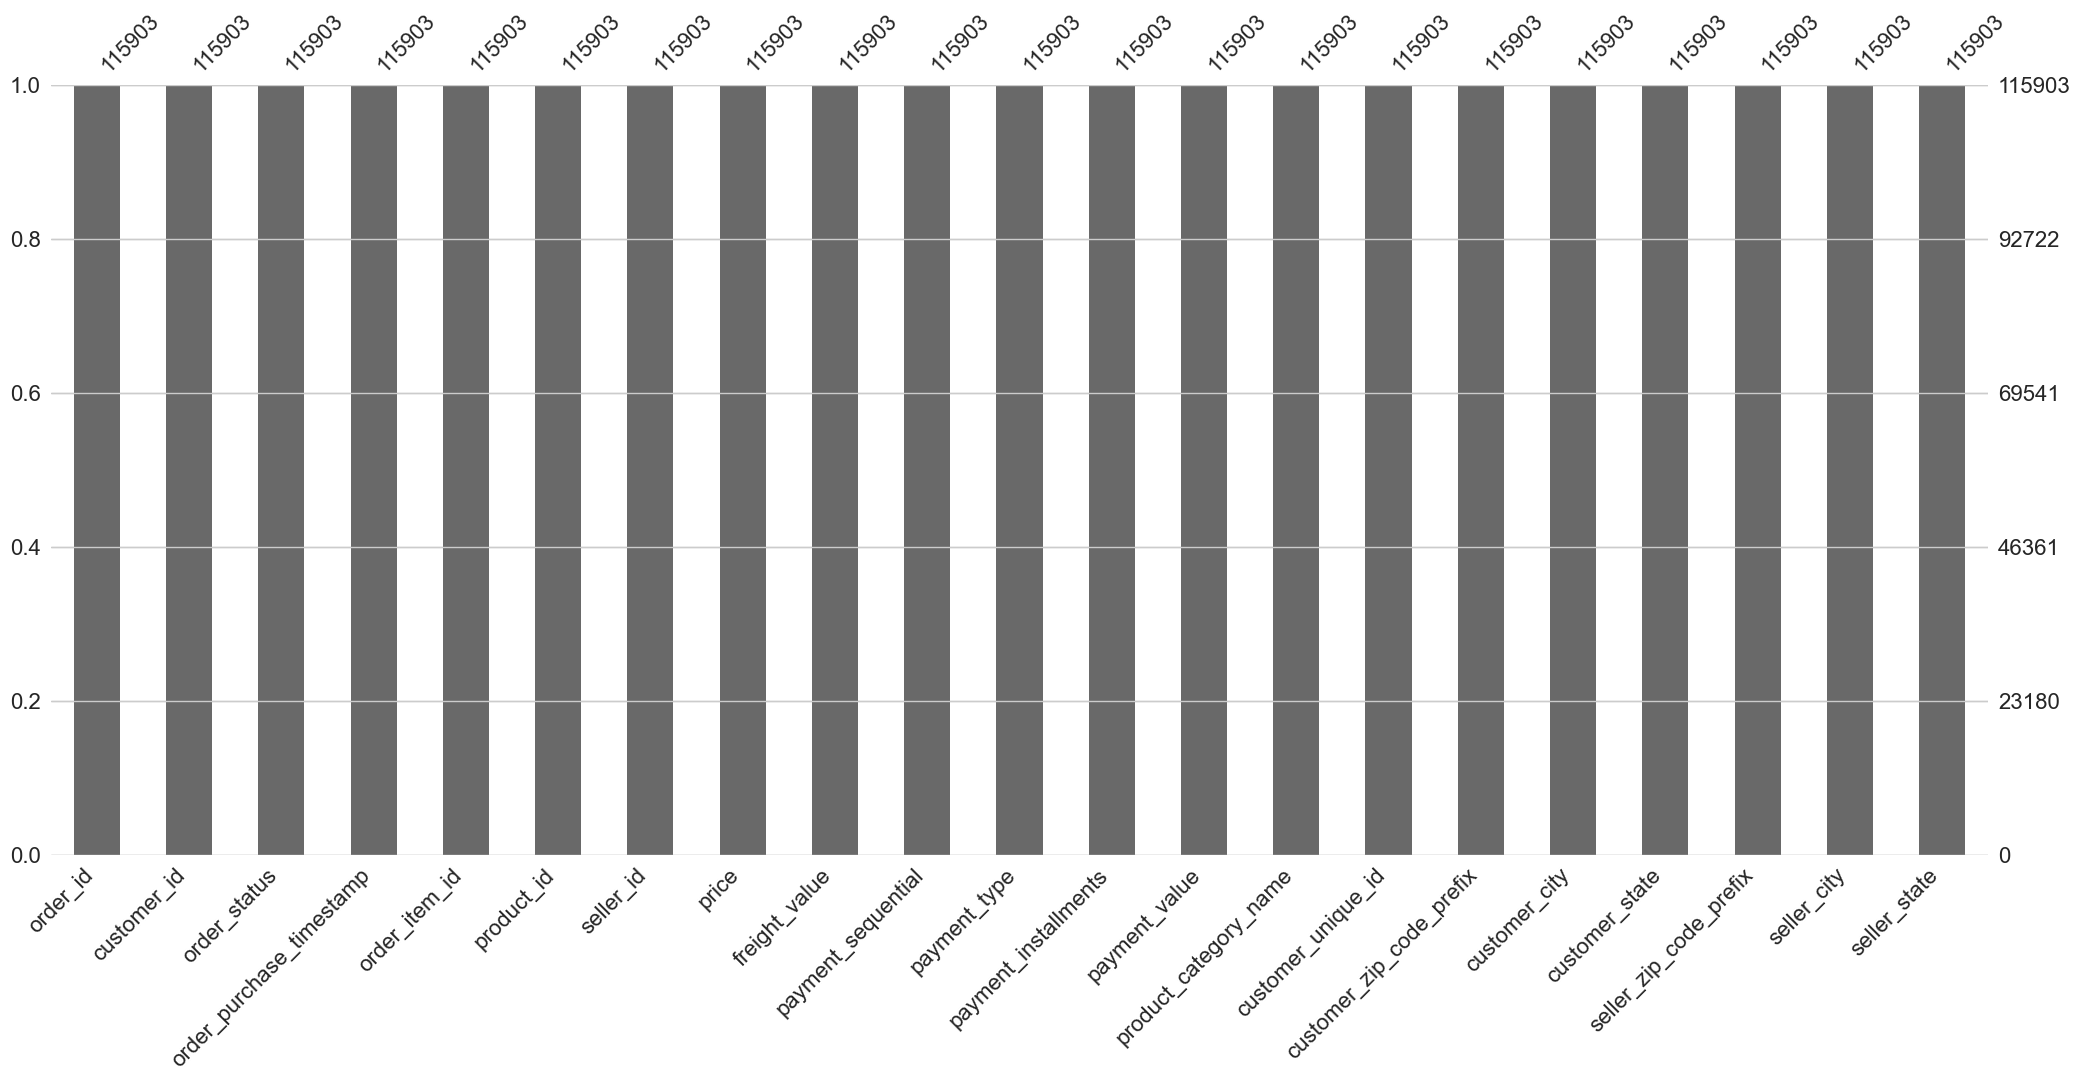

In [36]:
msno.bar(final_df, p=0.8, filter="top")

**Visualisation des caractéristiques quantitatives**

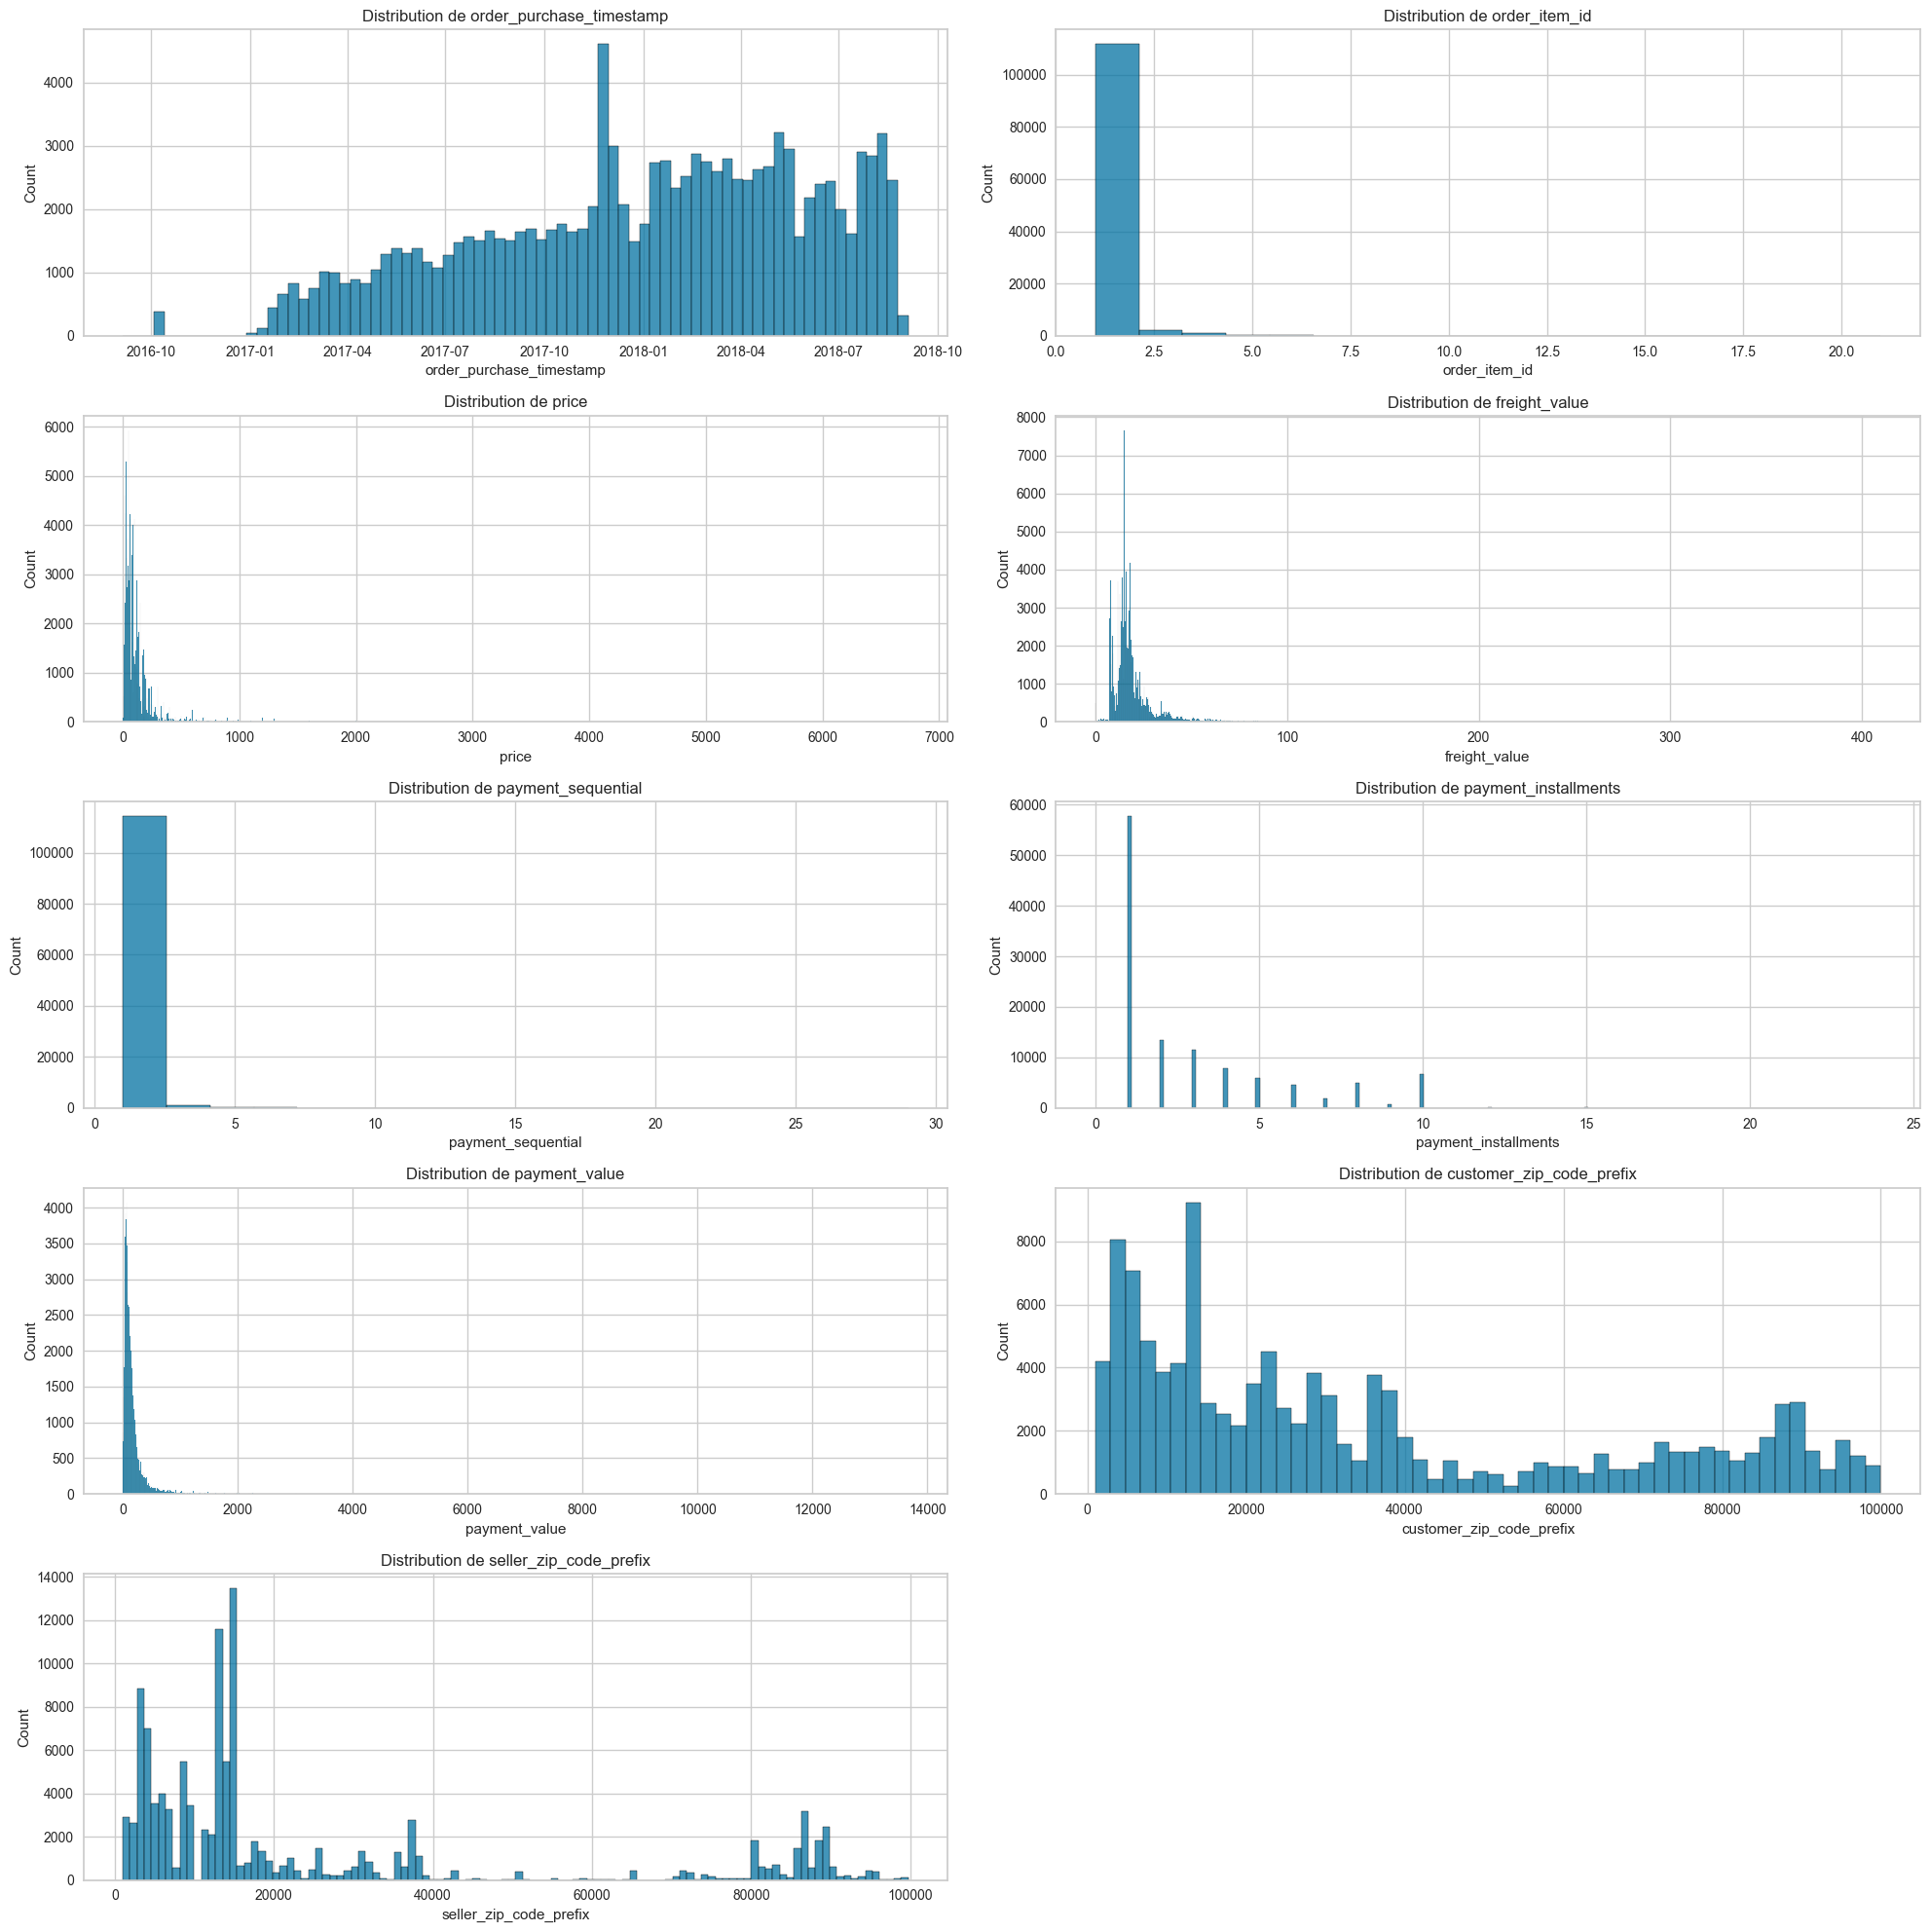

In [37]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20))

i = 0
j = 0
for feat in numerical_features:
    sns.histplot(final_df[feat], ax=axes[i,j])
    axes[i, j].set_title(f"Distribution de {feat}")
    j += 1
    if j == 2:
        i += 1
        j = 0
    if i == 5:
        break

fig.delaxes(axes[4, 1])


plt.tight_layout()
plt.show()

**Interpretations**

- Distribution de *order_purchase_timestamp*

Comme nous pouvons le voir sur le graphique, le nombre de commandes semble présenter de grandes variations au fil du temps, atteignant un pic vers le milieu de l'année 2018. Il pourrait être nécessaire de tracer la distribution en fonction du mois et de l'année pour mieux comprendre son évolution.

- Distribution de *order_item_id*

Comme nous pouvons le voir sur le graphique, la plupart des commandes comportent très peu d'articles, principalement autour de 1 à 2 articles.

- Distribion de *price*, *freight_value* and *payment_value*

Comme nous pouvons le voir, la plupart des prix sont concentrés sur les valeurs les plus basses, ce qui rend la distribution asymétrique. De même, pour la *freight_value* et la *payment_value*, la plupart des valeurs sont relativement faibles.</br>Il pourrait être utile d'effectuer une transformation logarithmique afin de normaliser ces distributions, car elles sont directement utilisées dans l'analyse RFM.

- Distribution de *payment_sequnetial*

Comme nous pouvons le voir sur la distribution, la plupart des paiements sont réglés en une seule fois, avec très peu de paiements effectués en plusieurs séquences.

- Distribution de *payment_installments*

Comme nous pouvons le constater, la majorité des clients optent pour un nombre réduit de paiements échelonnés, avec une tendance à la baisse à mesure que le nombre de paiements augmente.

- Distribution de *customer_zip_code_prefix* and *seller_zip_code_prefix* 

Ces distributions indiquent qu'il existe une base de clients et de vendeurs diversifiée, répartie sur divers codes postaux et états, certaines zones ayant une densité plus élevée. Il pourrait être intéressant d'explorer plus en profondeur les données de localisation par la suite.

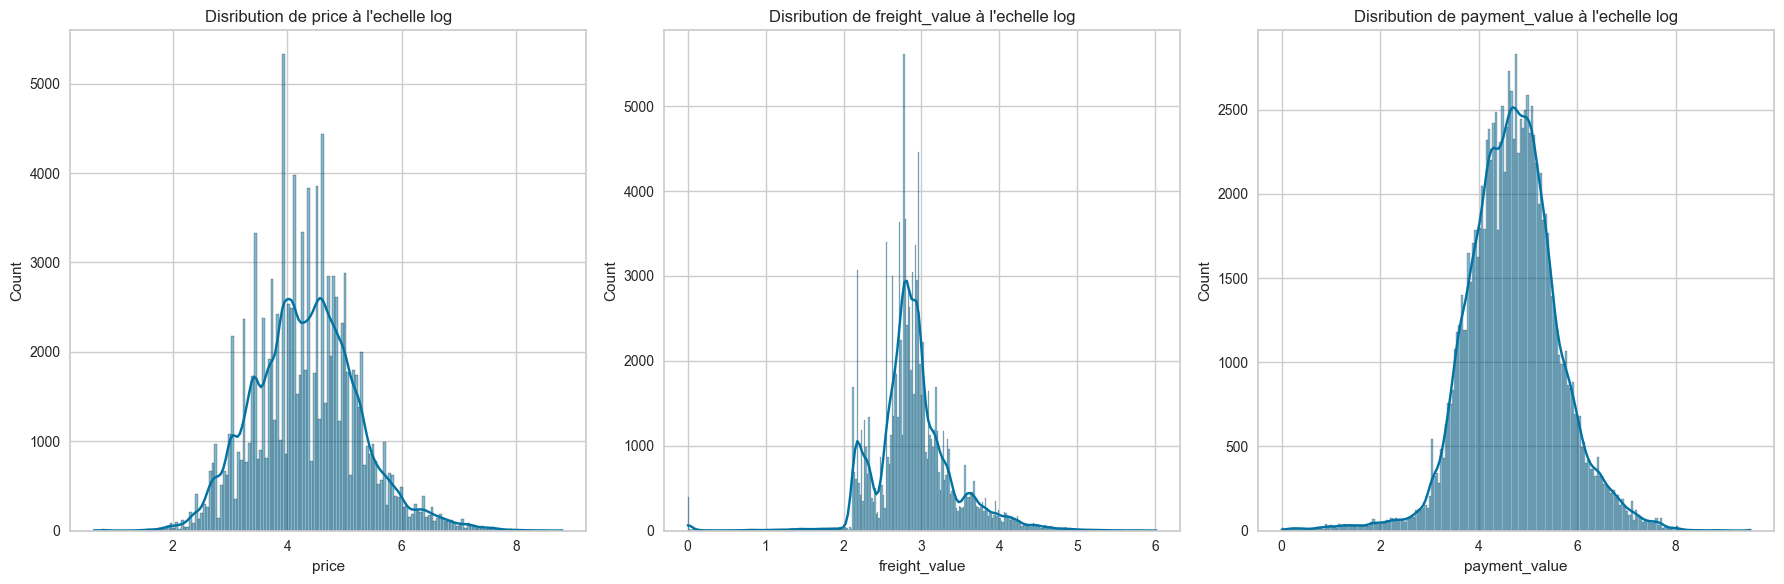

In [38]:
log_transform_columns = ["price", "freight_value", "payment_value"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i in range(len(log_transform_columns)):
    sns.histplot(np.log1p(final_df[log_transform_columns[i]]), ax=axes[i], kde=True)
    axes[i].set_title(f"Disribution de {log_transform_columns[i]} à l'echelle log")

plt.tight_layout()
plt.show()

Comme nous pouvons le voir la transformation à l'échelle logarithme aide quelque peu à normaliser la distribution bien qu'insuffisante

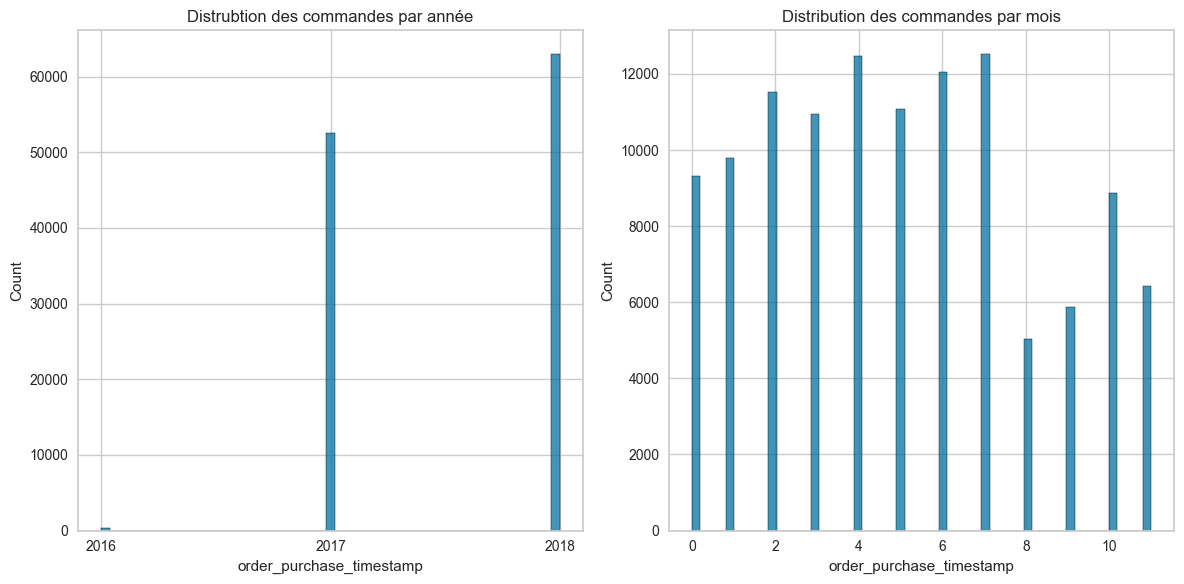

In [39]:
order_purchase_year = final_df["order_purchase_timestamp"].dt.year
order_purchase_month = final_df["order_purchase_timestamp"].dt.month - 1

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(order_purchase_year, ax=axes[0])
unique_years = sorted(order_purchase_year.unique())
axes[0].set_xticks(unique_years)
axes[0].set_xticklabels(unique_years)
axes[0].set_title("Distrubtion des commandes par année")
sns.histplot(order_purchase_month, ax=axes[1])
axes[1].set_title("Distribution des commandes par mois")


plt.tight_layout()
plt.show()

Nous pouvons constaté que le nombre de commandes portant sur 2016 est faible donc nous allons supprimer ces lignes de notre jeu de données

In [40]:
final_df['year'] = order_purchase_year
final_df = final_df[final_df['year'] != 2016].copy()
final_df.drop("year", axis=1, inplace=True)

#### Visualisation pour les caractéristiques qualitatives

In [41]:
categorical_features

Index(['order_id', 'customer_id', 'order_status', 'product_id', 'seller_id',
       'payment_type', 'product_category_name', 'customer_unique_id',
       'customer_city', 'customer_state', 'seller_city', 'seller_state'],
      dtype='object')

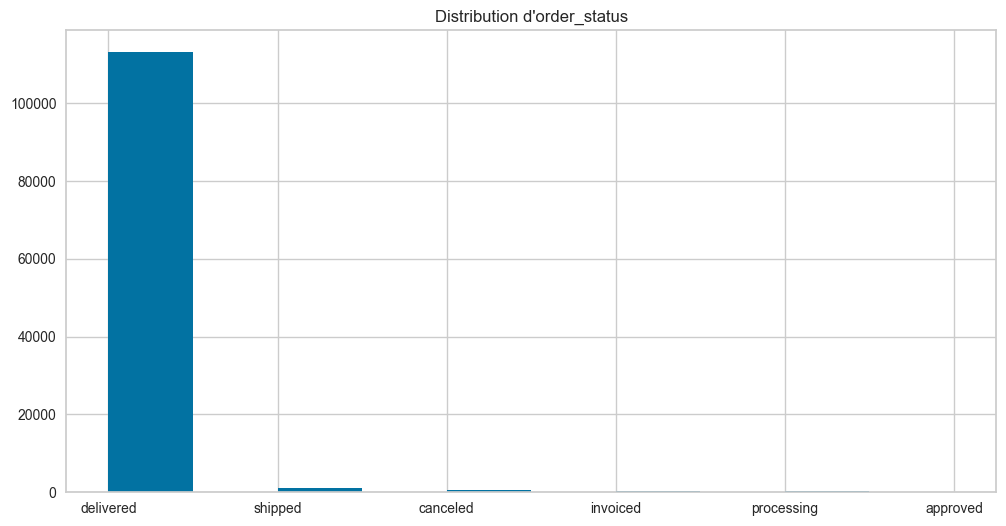

In [42]:
plt.figure(figsize=(12, 6))
plt.hist(final_df["order_status"])
plt.title("Distribution d'order_status")
plt.show()

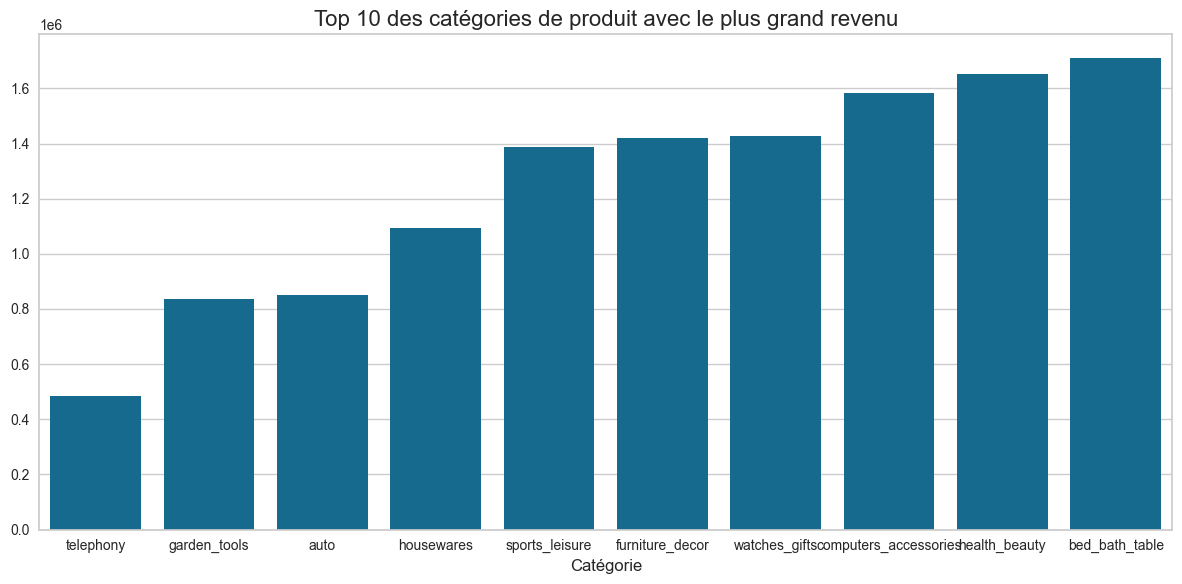

In [43]:
top_10_product = final_df['product_category_name'].value_counts().sort_values(ascending=False).head(10).index
df_top_10_product = final_df[final_df['product_category_name'].isin(top_10_product)]
df_price_cat = final_df['payment_type'].value_counts().sort_values()/len(final_df['payment_type'])*100


plt.figure(figsize=(12, 6))
df_top10 = df_top_10_product.groupby('product_category_name')['payment_value'].sum().sort_values()
sns.barplot(x=df_top10.index, y=df_top10.values)    
plt.title('Top 10 des catégories de produit avec le plus grand revenu', size=16)
plt.xlabel('Catégorie',size=12)
plt.tight_layout()
plt.show()

Comme nous pouvons le voir les catégories bed_bath_table, healh_beauty et computer accessories sont celles qui apportent le plus de revenu

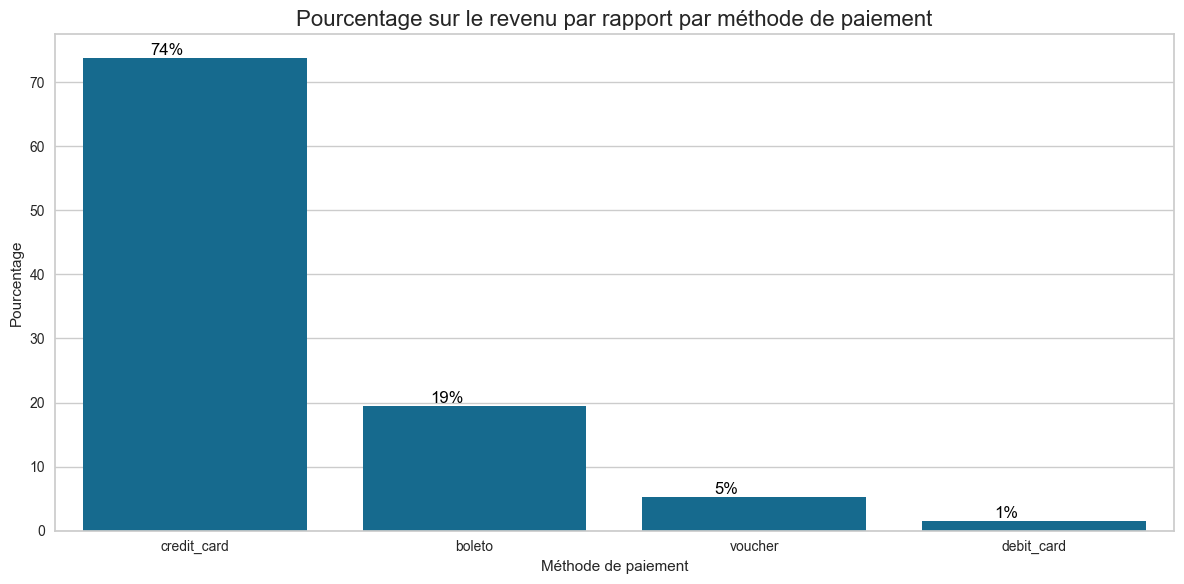

In [44]:
plt.figure(figsize=(12, 6))
df_pay_type = final_df['payment_type'].value_counts()/len(final_df['payment_type'])*100
graph = sns.barplot(x=df_pay_type.index, y=df_pay_type.values)  
for p in graph.patches:
        graph.annotate('{:.0f}%'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')
plt.title('Pourcentage sur le revenu par rapport par méthode de paiement', size=16)
plt.ylabel('Pourcentage')
plt.xlabel('Méthode de paiement')
plt.tight_layout()
plt.show()

Comme nous pouvons le voir la majorité des transactions sont faites par carte de crédit avec 74% suivi de boleto qui correspond à une méthode de paiement par cash avec 19%.
Ceci peut traduire une opportunité d'attirer de nouveaux utilisateurs e-commerce traduisant l'opportunité de travailler avec des fournisseurs de cartes de crédit pour proposer des promotions ou des cartes de fidélité afin d'attirer de nouveaux utilisateurs et de fidéliser les utilisateurs existants.

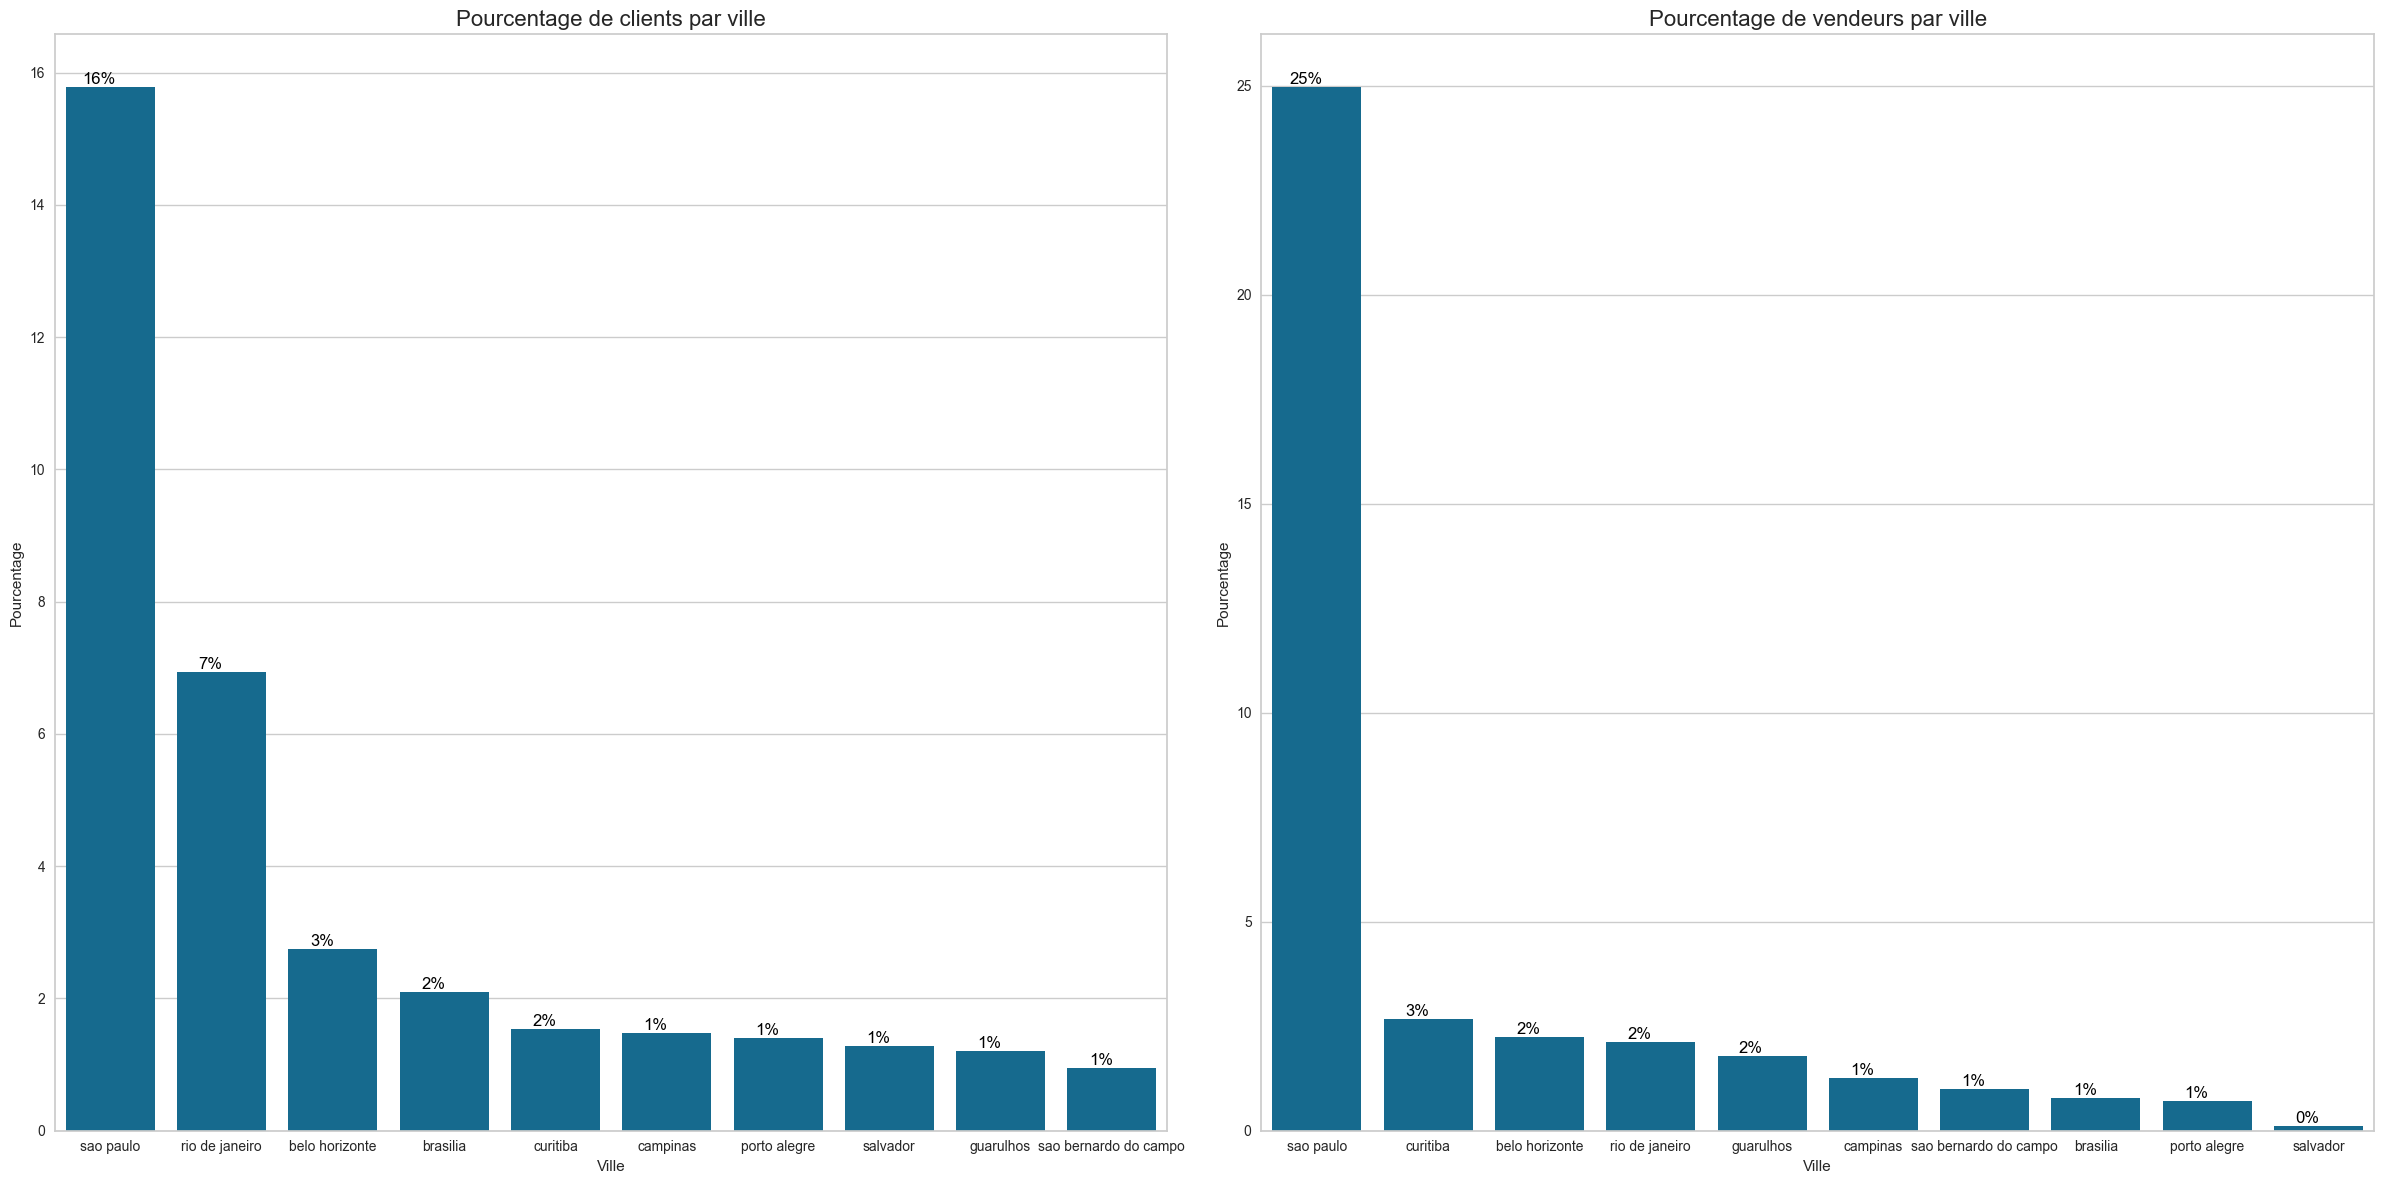

In [45]:
top_10_customer_city = final_df['customer_city'].value_counts().sort_values(ascending=False).head(10).index
df_top_10_customer_city = final_df[final_df['customer_city'].isin(top_10_customer_city)]
top_10_seller_city = final_df['seller_city'].value_counts().sort_values(ascending=False).head(10).index
df_top_10_seller_city = final_df[final_df['seller_city'].isin(top_10_customer_city)]

fig, axes  = plt.subplots(1,2,figsize=(24, 12))

df_customer = df_top_10_customer_city['customer_city'].value_counts()/len(final_df['customer_city'])*100
graph = sns.barplot(x=df_customer.index, y=df_customer.values, ax=axes[0])
for p in graph.patches:
        graph.annotate('{:.0f}%'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')
axes[0].set_title('Pourcentage de clients par ville', size=16)
axes[0].set_ylabel('Pourcentage')
axes[0].set_xlabel('Ville')

df_seller = df_top_10_seller_city['seller_city'].value_counts()/len(final_df['seller_city'])*100
graph = sns.barplot(x=df_seller.index, y=df_seller.values, ax=axes[1])
for p in graph.patches:
        graph.annotate('{:.0f}%'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')
axes[1].set_title('Pourcentage de vendeurs par ville', size=16)
axes[1].set_ylabel('Pourcentage')
axes[1].set_xlabel('Ville')


plt.tight_layout()
plt.show()

Comme nous pouvons le voir Sao Paulo a le plus grand nombre de clients car c'est la plus grande ville du Brésil. Elle est suivie par Rio de Janeiro, qui est la capitale de l'État de Rio de Janeiro. En conclusion, les capitales d'État ont la plus grande activité probablement en raison du nombre élevé de personnes y vivant.</br>
Nous avons de la même façon un nombre important de vendeurs sur Sao Paulo avec 25%, avec le nombre de vendeurs dans les autres villes qui ne dépassent pas 5%.

In [46]:
profile = ProfileReport(final_df, title="Profiling Report")
profile.to_file(f"olist_segmentation_profiling.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 169.98it/s]


### Feature Engineering

Le jeu de données est actuellement centré sur les commandes ce qui pose des défis pour la segmentation des clients.</br>
Pour réaliser une segmentation efficace, les données doivent être restructurées pour se concentrer sur les clients plutôt que sur les commandes, ce qui nécessite la création de caractéristiques pour créer des caractéristiques agrégés pour chaque client. Cette transformation permettra d'effectuer une segmentation en fonction de leur comportement d'achat et de prédire le comportement futur. Sans cette approche, les informations seraient limitées aux niveaux de commande.</br>

Nous procédons donc à créer des variables qui nous permettrons de traduire le comportement des clients. Pour celà nous avons fait le choix sur les variables suivantes:

1. **total_spent**: Le montant total d'argent dépensé par un client sur la plateforme sur une période spécifiée.

2. **frequency**: Le nombre d'achats ou de commandes effectués par le client

3. **unique_categories**: Le nombre de catégories de produits distinctes à partir desquelles le client a acheté

4. **avg_installments**: Le nombre moyen de paiements échelonnés choisis par un client pour ses achats.

5. **total_items**: Le nombre total d'articles achetés

6. **unique_sellers**: Le nombre de vendeurs distincts auprès desquels le client a acheté

7. **payment_price_ratio**: Le rapport entre le prix payé et le prix initial du produit

8. **recency**: Le temps écoulé depuis la dernière commande passée

9. **avg_fractional_payment_ratio**:  La proportion des paiements effectués en plusieurs fois par rapport aux paiements en une seule fois

10. **total_freight_value**: Le montant total payé pour les frais de livraison

In [47]:
# Total Spent
total_spent =final_df.groupby('customer_unique_id')['price'].sum().reset_index()
total_spent.columns = ['customer_unique_id', 'total_spent']


# Fréquency
frequency =final_df.groupby('customer_unique_id')['order_id'].count().reset_index()
frequency = frequency.rename({'order_id':'frequency'},axis = 1)

# Unique categories
unique_categories =final_df.groupby('customer_unique_id')['product_category_name'].nunique().reset_index()
unique_categories.columns = ['customer_unique_id', 'unique_categories']

# Avg installment
avg_installments =final_df.groupby('customer_unique_id')['payment_installments'].mean().reset_index()
avg_installments.columns = ['customer_unique_id', 'avg_installments']

# Total items
total_items =final_df.groupby('customer_unique_id')['order_item_id'].sum().reset_index()
total_items.columns = ['customer_unique_id', 'total_items']

# Unique sellers
unique_sellers =final_df.groupby('customer_unique_id')['seller_id'].nunique().reset_index()
unique_sellers.columns = ['customer_unique_id', 'unique_sellers']


# Payment price ratio
payment_price_ratio =final_df.groupby('customer_unique_id')['payment_value'].sum() /final_df.groupby('customer_unique_id')['price'].sum()
payment_price_ratio = payment_price_ratio.reset_index()
payment_price_ratio.columns = ['customer_unique_id', 'payment_price_ratio']

# Recency
last_order =final_df.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
last_order.columns = ['customer_unique_id', 'last_order']
last_order['recency'] = (last_order['last_order'].max() - last_order['last_order']).dt.days


# Avg fractional payment ration
avg_fractional_payment_ratio =final_df.groupby('customer_unique_id')['payment_installments'].mean() /final_df.groupby('customer_unique_id')['payment_value'].sum()
avg_fractional_payment_ratio = avg_fractional_payment_ratio.reset_index()
avg_fractional_payment_ratio.columns = ['customer_unique_id', 'avg_fractional_payment_ratio']

# Total freight
total_freight_value = final_df.groupby('customer_unique_id')['freight_value'].sum().reset_index()
total_freight_value.columns = ['customer_unique_id', 'total_freight_value']

In [48]:
df_features = pd.merge(total_spent, frequency[['customer_unique_id', 'frequency']], on='customer_unique_id', how='left')
df_features = pd.merge(df_features, unique_categories, on='customer_unique_id', how='left')
df_features = pd.merge(df_features, avg_installments, on='customer_unique_id', how='left')
df_features = pd.merge(df_features, total_items, on='customer_unique_id', how='left')
df_features = pd.merge(df_features, unique_sellers, on='customer_unique_id', how='left')
df_features = pd.merge(df_features, payment_price_ratio, on='customer_unique_id', how='left')
df_features = pd.merge(df_features, last_order[['customer_unique_id', 'recency']], on='customer_unique_id', how='left')
df_features = pd.merge(df_features, avg_fractional_payment_ratio, on='customer_unique_id', how='left')
df_features = pd.merge(df_features, total_freight_value, on='customer_unique_id', how='left')
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93811 entries, 0 to 93810
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_unique_id            93811 non-null  object 
 1   total_spent                   93811 non-null  float64
 2   frequency                     93811 non-null  int64  
 3   unique_categories             93811 non-null  int64  
 4   avg_installments              93811 non-null  float64
 5   total_items                   93811 non-null  float64
 6   unique_sellers                93811 non-null  int64  
 7   payment_price_ratio           93811 non-null  float64
 8   recency                       93811 non-null  int64  
 9   avg_fractional_payment_ratio  93811 non-null  float64
 10  total_freight_value           93811 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 7.9+ MB


In [49]:
df_features.head(10)

,customer_unique_id,total_spent,frequency,unique_categories,avg_installments,total_items,unique_sellers,payment_price_ratio,recency,avg_fractional_payment_ratio,total_freight_value
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,1,8.0,1.0,1,1.092379,115,0.056378,12.00
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,1,1.0,1.0,1,1.438624,118,0.036778,8.29
2,0000f46a3911fa3c0805444483337064,69.00,1,1,8.0,1.0,1,1.249565,541,0.092786,17.22
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,1,4.0,1.0,1,1.678338,325,0.091701,17.63
4,0004aac84e0df4da2b147fca70cf8255,180.00,1,1,6.0,1.0,1,1.093833,292,0.030474,16.89
5,0004bd2a26a76fe21f786e4fbd80607f,154.00,1,1,8.0,1.0,1,1.084286,150,0.047910,12.98
6,00050ab1314c0e55a6ca13cf7181fecf,27.99,1,1,1.0,1.0,1,1.264023,135,0.028265,7.39
7,00053a61a98854899e70ed204dd4bafe,382.00,2,1,3.0,3.0,1,2.194660,186,0.003578,37.18
8,0005e1862207bf6ccc02e4228effd9a0,135.00,1,1,3.0,1.0,1,1.112000,547,0.019984,15.12
9,0005ef4cd20d2893f0d9fbd94d3c0d97,104.90,1,1,4.0,1.0,1,1.236988,174,0.030826,24.86


**Distribution des variables**

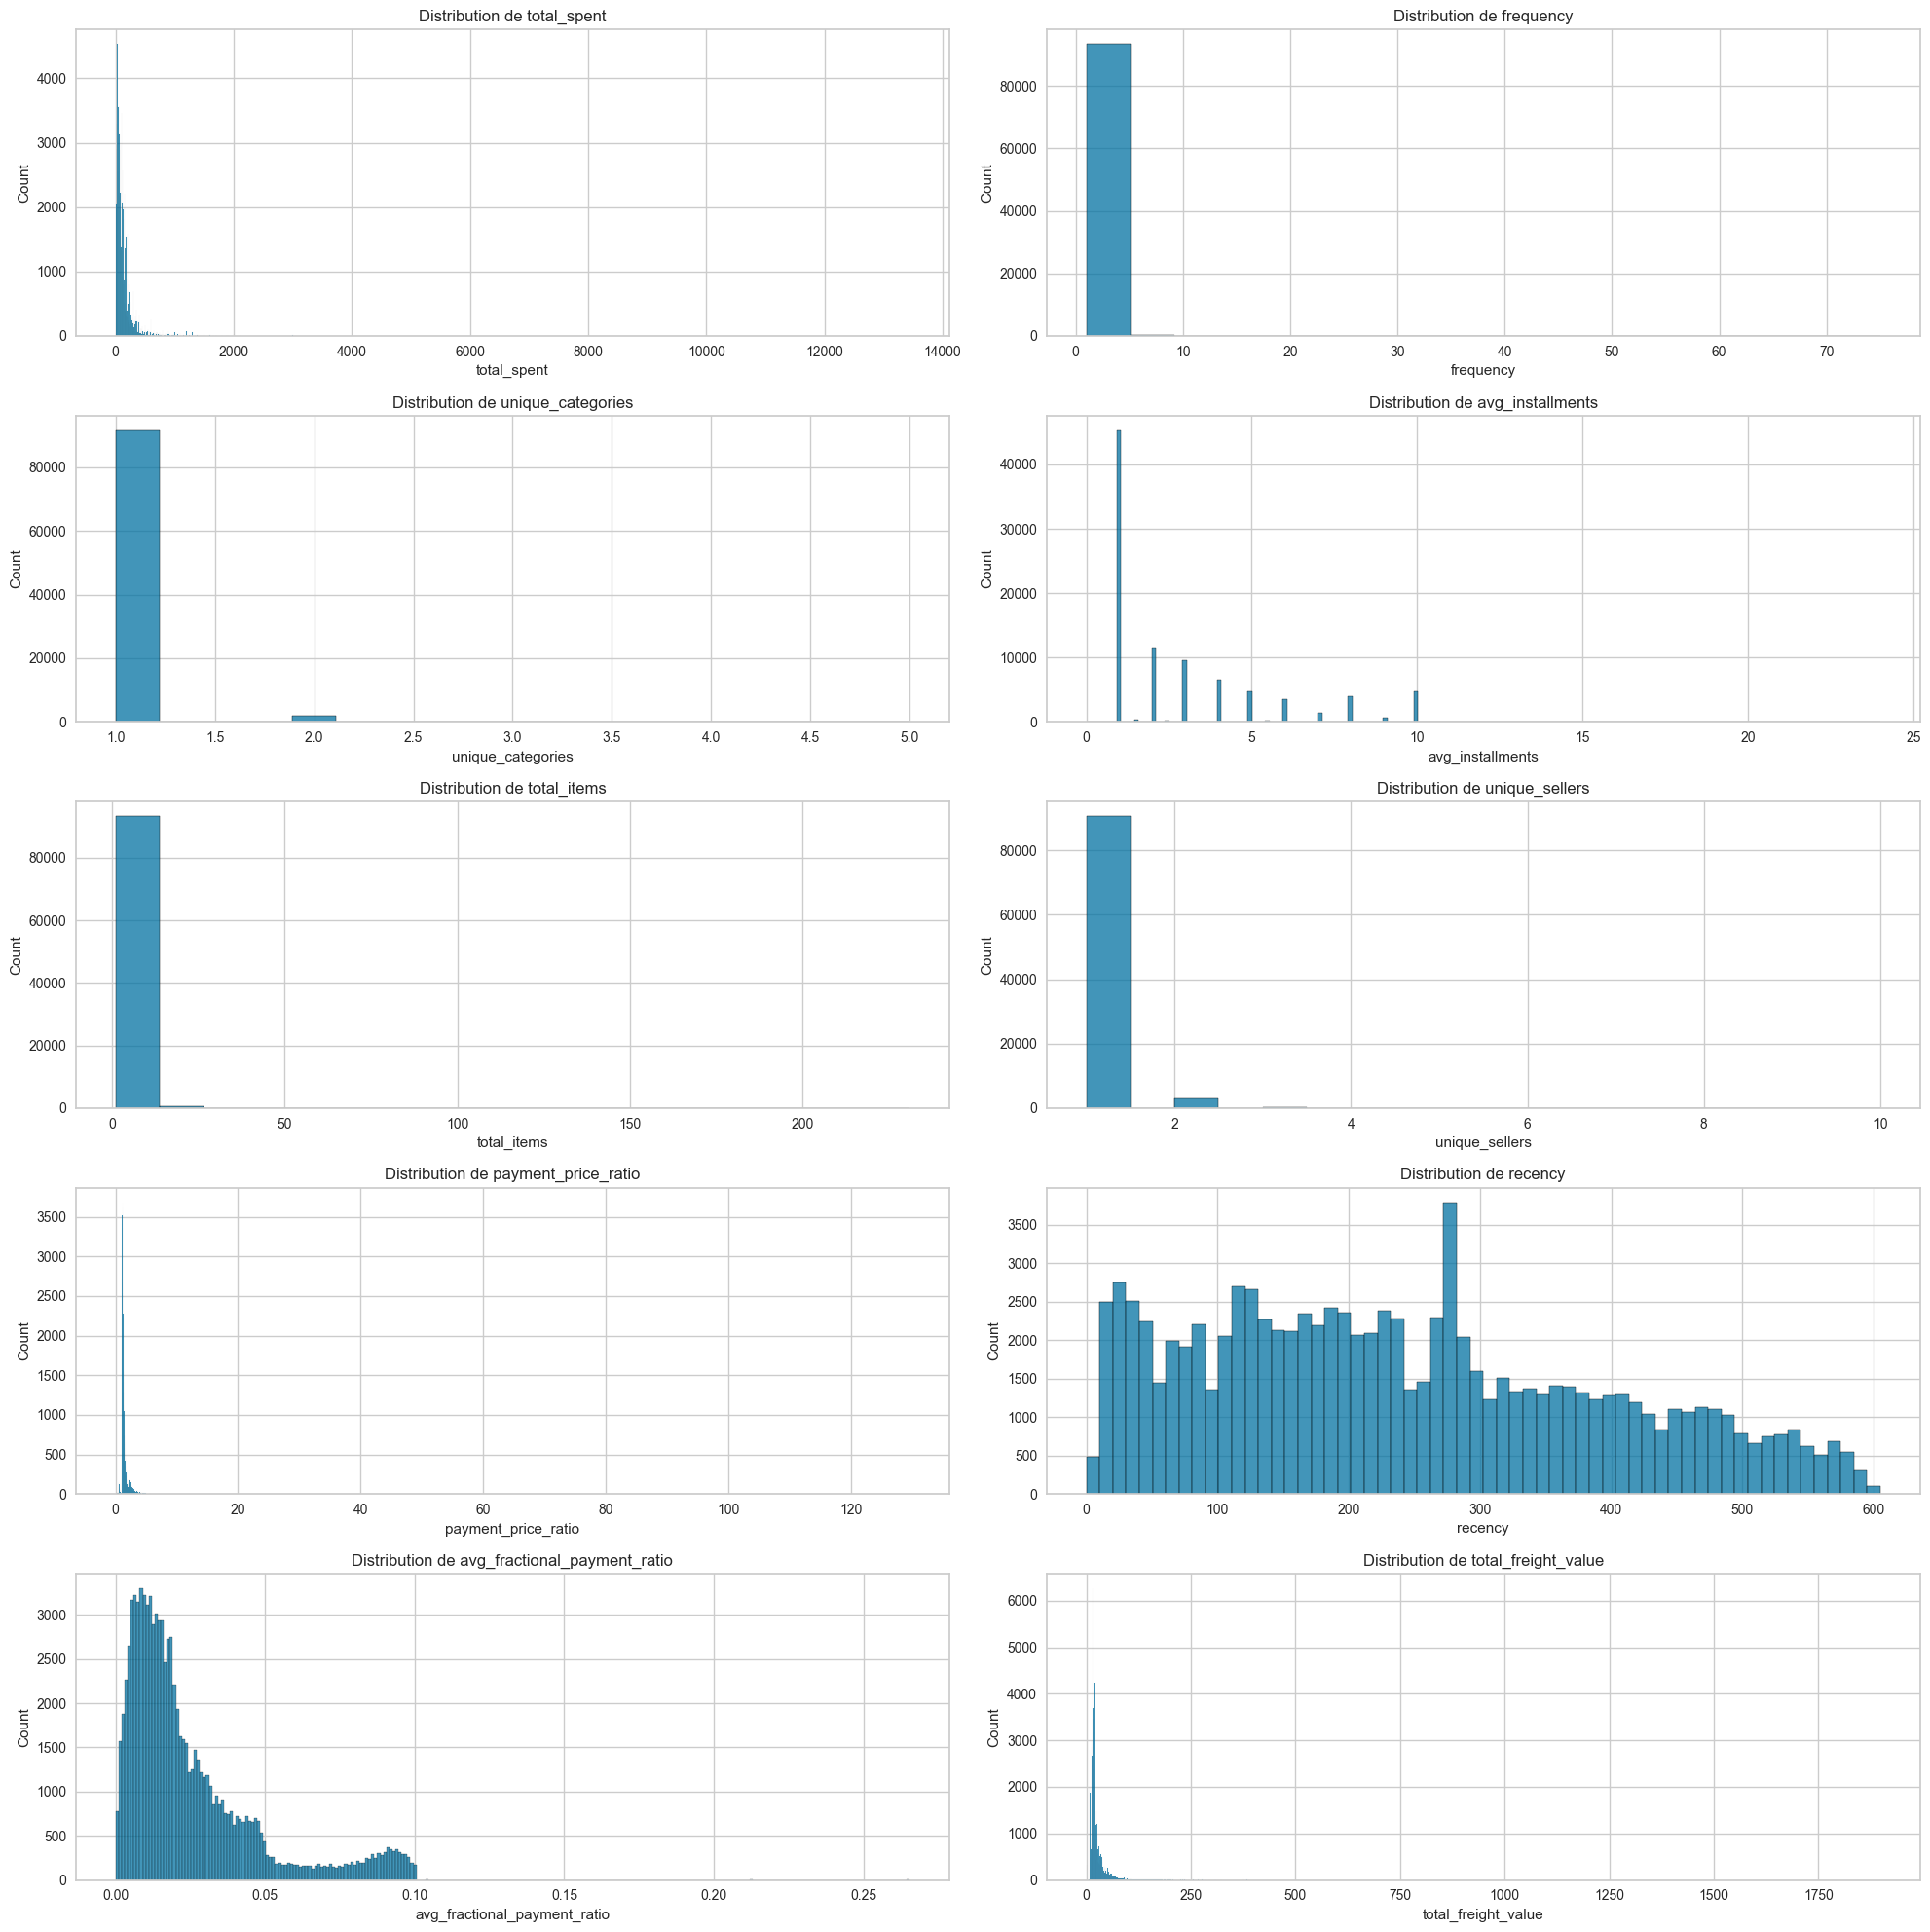

In [50]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20))

i = 0
j = 0
for feat in df_features.drop('customer_unique_id', axis=1).columns:
    sns.histplot(df_features[feat], ax=axes[i,j])
    axes[i, j].set_title(f"Distribution de {feat}")
    j += 1
    if j == 2:
        i += 1
        j = 0
    if i == 5:
        break

plt.tight_layout()
plt.show()

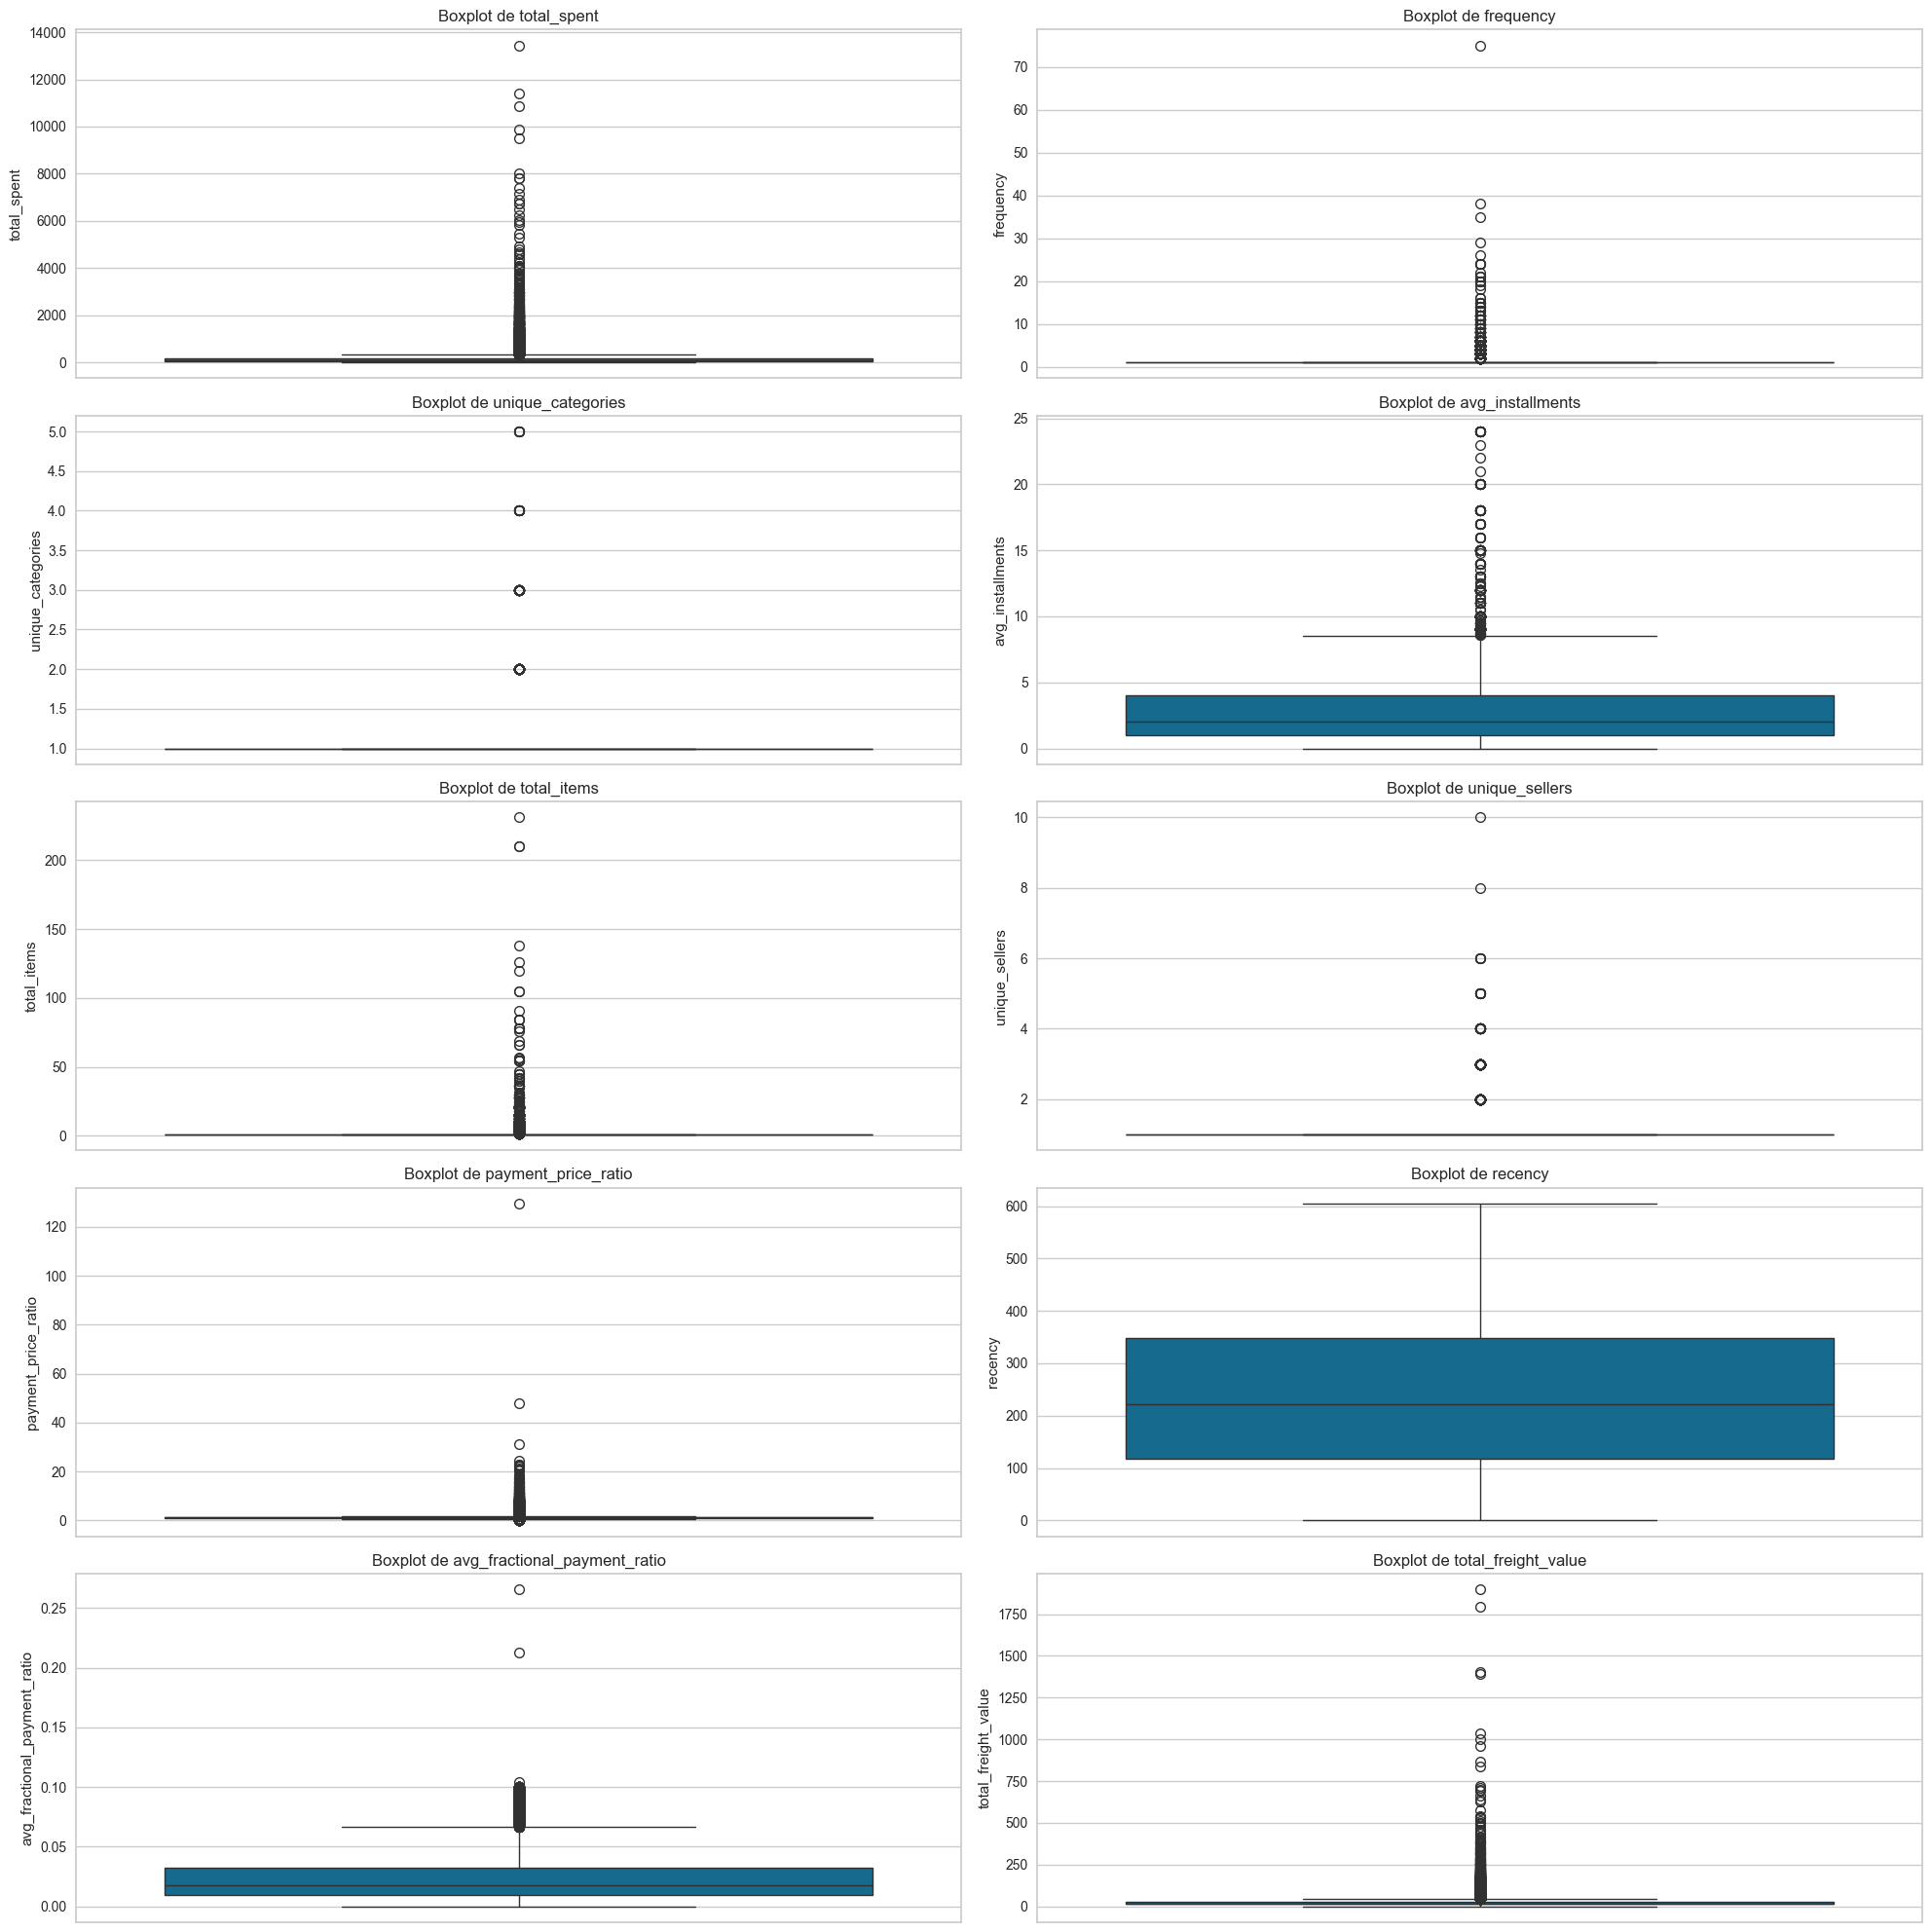

In [51]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20))

i = 0
j = 0
for feat in df_features.drop('customer_unique_id', axis=1).columns:
    sns.boxplot(df_features[feat], ax=axes[i,j])
    axes[i, j].set_title(f"Boxplot de {feat}")
    j += 1
    if j == 2:
        i += 1
        j = 0
    if i == 5:
        break

plt.tight_layout()
plt.show()

**Interprétations**

- Total spent

   On peut voir que la majorité des clients dépensent une petite somme d'argent avec quelques clients dépensant des montants beaucoup plus élevés. Le boxplot confirme l'existence de nombreux outliers avec des clients dépensant des montants exceptionnellement élevés.

- Frequency 

   La plupart des clients effectuent très peu d'achats, généralement un ou deux. La distribution diminue rapidement. Le boxplot Montre plusieurs outliers avec des clients effectuant un grand nombre d'achats.

- Unique categories et Unique sellers

   La plupart des clients achètent dans une seule catégorie de produits et auprès d'un seul vendeur. Les boxplots confirme ces tendances avec quelques outliers. Ces variables n'apportent donc pas bcp d'informations nous allons la supprimer du jeu de données

- avg_installements

   La plupart des clients ne choisissent pas de payer en plusieurs fois, mais certains choisissent de payer en plusieurs mensualités. Le boxplot indique la présence d'un grand nombre d'outliers avec des clients choisissant un nombre élevé de mensualités.

- total_items

   La plupart des clients achètent très peu d'articles, souvent un seul. Le boxplot Montre de nombreux outliers où les clients achètent un grand nombre d'articles.
   
- payment_price_ratio

   La majorité des paiements sont très proches du prix initial, mais certains ratios peuvent être beaucoup plus élevés indiquant peut être des réductions. Le boxplot montre plusieurs outliers où le ratio de paiement est exceptionnellement élevé.

- recency

   Les clients montrent une diversité de récence dans leurs achats, avec une répartition uniforme. Le boxplot montre une distribution large sans trop d'outliers significatifs.

- avg_fractional_payment_ratio

   La majorité des clients effectuent des paiements sans fractionnement, mais il y a une diversité dans les ratios fractionnés. Le boxplot montre plusieurs outliers avec des ratios de paiements fractionnés plus élevés.

- total_freight_value

   La majorité des clients paient peu pour la livraison, mais certains frais de livraison sont beaucoup plus élevés. Le boxplot ndique la présence de nombreux outliers où les frais de livraison sont exceptionnellement élevés.

In [52]:
df_features.drop(columns=["unique_categories", "unique_sellers"], inplace=True)

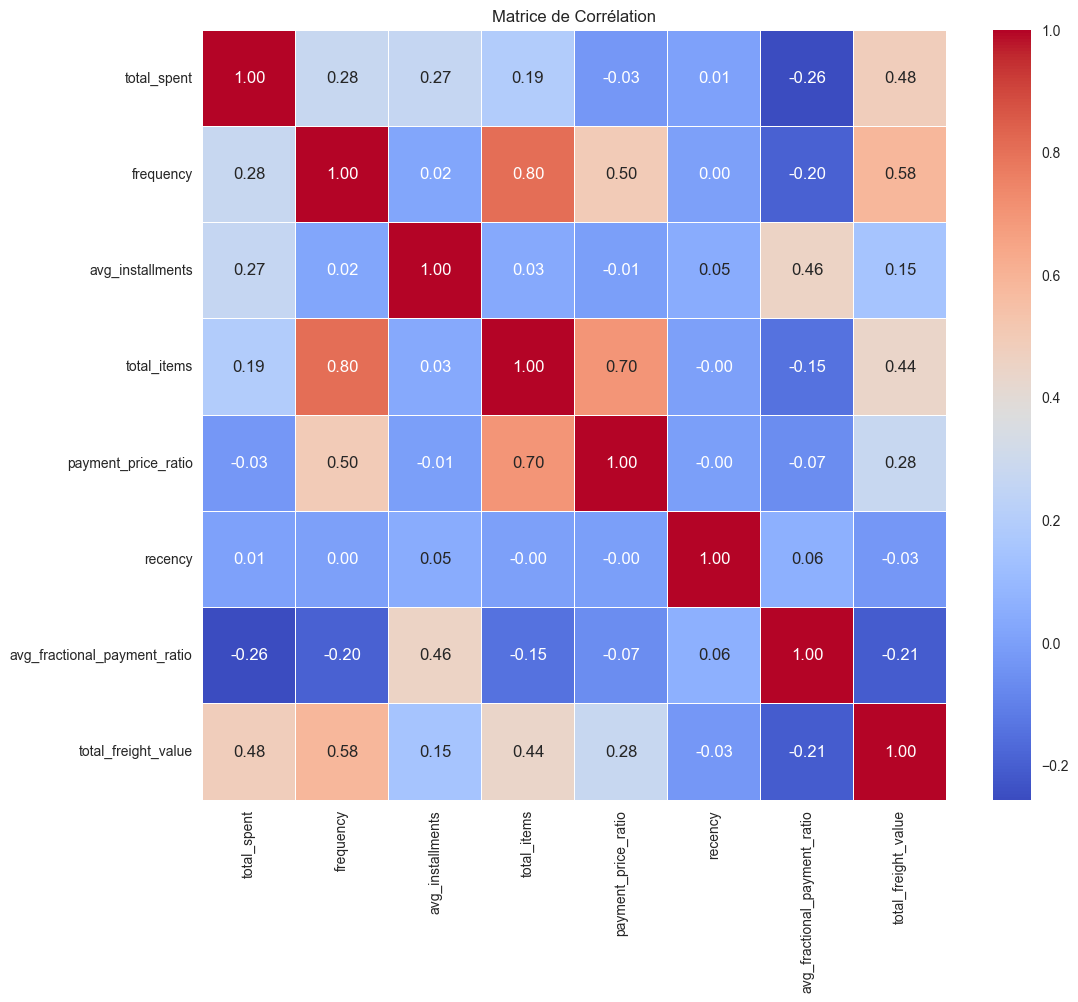

In [53]:
corr_matrix = df_features.drop("customer_unique_id", axis=1).corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de Corrélation')
plt.show()

**Interprétations**

Ces corrélations peuvent aider à comprendre les comportements d'achat des clients et à identifier les facteurs qui influencent les dépenses totales et la fréquence d'achat.

1. Corrélations fortes (>0.7) :
   - Fréquence et total_items (0.81), les clients achètent rarement plus d'un item par commandes 
   - Total_items et payment_price_ratio (0.72), les clients achète plusieurs items lors de période de réduction

2. Corrélations modérées (0.4-0.7) :
   - Total_freight_value et plusieurs variables (total_spent, frequency, total_items) : La valeur du transport est modérément liée aux dépenses totales, à la fréquence d'achat et au nombre d'articles.
   - Avg_installments et avg_fractional_payment_ratio (0.46) : Le nombre moyen de versements est modérément corrélé au ratio de paiement fractionné moyen.

3. Corrélations faibles ou négligeables :
   - Recency avec la plupart des autres variables : Cela suggère que la récence des achats n'a pas beaucoup d'impact sur les autres métriques.
   - Total_spent et payment_price_ratio (-0.03) : Pas de lien significatif entre les dépenses totales et le ratio de prix de paiement.

### Model Building

Après notre analyse exploratoire des données ainsi que le feature engineering, nous allons donc procéder au clustering des clients. Nous avons décider de tester trois approches de clustering KMeans, GaussianMixture et DBSCAN</br>

<img src="https://media.licdn.com/dms/image/D5612AQEbR-vj1LqUFw/article-cover_image-shrink_600_2000/0/1693362637757?e=2147483647&v=beta&t=yD-EP9-YR-_gitRaxxiAGd5jzvvlnrjyzuSgVfXYDQY" alt="dataset_configuration" width="1200"/>

**Détermination du nombre de clusters optimal pour chaque modèle**

In [54]:
X = df_features.drop("customer_unique_id", axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
model = PCA(n_components=0.95)
X_transformed = model.fit_transform(X_scaled)

KMeans

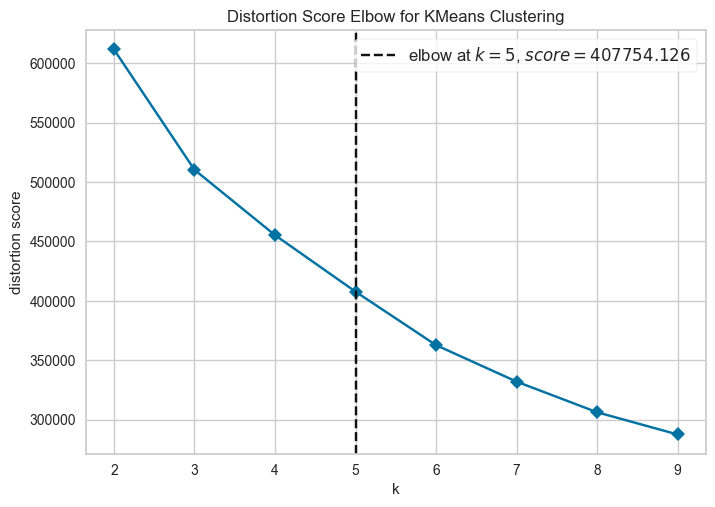

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [55]:
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(2,10), timings=False)
visualizer.fit(X_transformed)
visualizer.show()

In [56]:
n_clusters_kmeans = visualizer.elbow_value_

GaussianMixture

In [57]:
n_components = range(1, 11)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov, random_state = 42)
        gmm.fit(X_transformed)
        score.append((cov,n_comp,gmm.bic(X_transformed)))
score_1 = pd.DataFrame(score)
score_1.columns = ['Covariance_Type', 'N_Components','BIC_Score']
score_2 = score_1[score_1.BIC_Score == score_1.BIC_Score.min()]

score_2.head(n=2)

,Covariance_Type,N_Components,BIC_Score
39,full,10,-965921.288374


In [58]:
n_components_gauss = score_2.head(n=2).N_Components.values[0]

DBSCAN

0.49840190649148236


<Figure size 500x500 with 0 Axes>

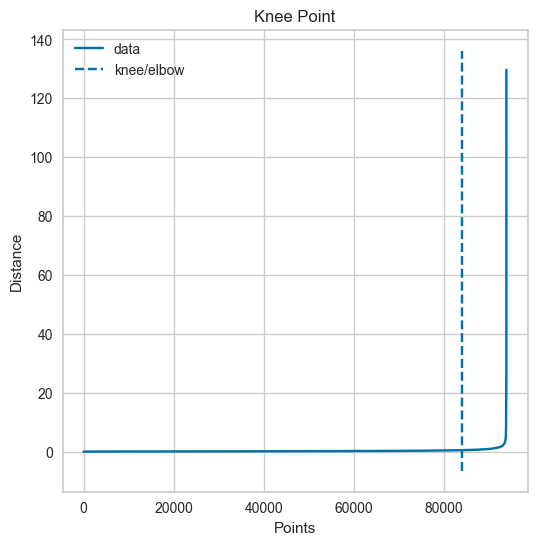

In [59]:
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(X_transformed)
distances, indices = neighbors.kneighbors(X_transformed)
distances = np.sort(distances[:,10], axis=0)


i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

In [60]:
eps_dbscan = distances[knee.knee]

**Entrainement et evaluation des modèles**

Nous créons les modèles avec les meilleurs paramètres précédemment trouvés et allons les évaluer afin de déterminer celui qui donne le meilleur clustering

In [61]:
ESTIMATOR_PARAMS = {
    "DBSCAN": {
        "estimator": DBSCAN,
        "params": {"eps": eps_dbscan, "min_samples": 2}
    },
    "KMeans": {
        "estimator": KMeans,
        "params": {"n_clusters": n_clusters_kmeans, "random_state": 42}
    },
    "GaussianMixture": {
        "estimator": GaussianMixture,
        "params": {"n_components": n_components_gauss, "random_state": 42}
    }
}

In [62]:
for model_name, model_config in ESTIMATOR_PARAMS.items():
    estimator = model_config["estimator"]
    params = model_config["params"]

    pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.95)),
            ('estimator', estimator(**params))
        ])
    
    pipeline.fit(X)

    if hasattr(pipeline.named_steps['estimator'], 'labels_'):
            labels = pipeline.named_steps['estimator'].labels_
    else:
        labels = pipeline.predict(X)

    if len(set(labels)) > 1:
            silhouette = silhouette_score(X, labels)
            calinski_harabasz = calinski_harabasz_score(X, labels)
            davies_bouldin = davies_bouldin_score(X, labels)

    print(f"Modèle: {pipeline[-1].__class__.__name__}")
    print(f"Silhouette Score: {silhouette} --- Calinski Score: {calinski_harabasz} --- Davies Score: {davies_bouldin}")

Modèle: DBSCAN
Silhouette Score: -0.8421570639054003 --- Calinski Score: 41.27951500707827 --- Davies Score: 3.180986870625262
Modèle: KMeans
Silhouette Score: 0.15032243282833976 --- Calinski Score: 11699.361908684092 --- Davies Score: 3.6408248188462777
Modèle: GaussianMixture
Silhouette Score: -0.03399756890023419 --- Calinski Score: 6330.485091158911 --- Davies Score: 10.442015187552043


En comparant les résultats obtenus, nous pouvons voir que le modèle KMeans présente les meilleurs performances avec le plus haut silhouette_socre et calinski_harabasz_score bien que le modèle DBSCAN présente un plus faible davies_bouldin_score.</br> Nous allons donc  sauvegarder et utiliser ce modèle dans la suite

**Interprétation des segments**

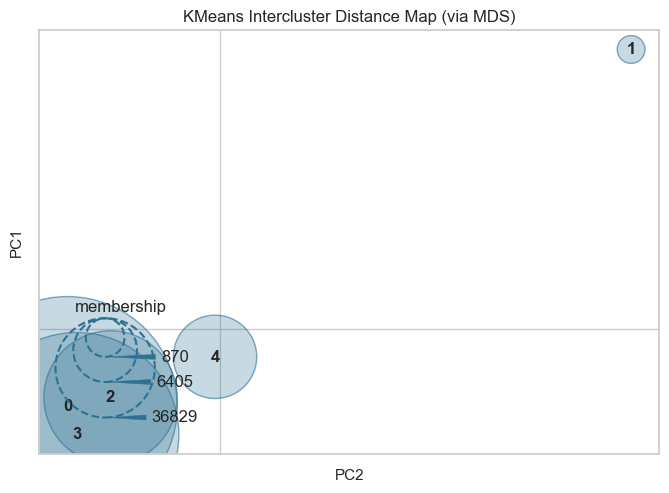

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [63]:
visualizer = InterclusterDistance(KMeans(n_clusters=n_clusters_kmeans, random_state=42))
visualizer.fit(X)
visualizer.show()

In [64]:
model = Pipeline([
            ('scaler', Standler()),
            ('pca', PCA(n_components=0.95)),
            ('estimator', KMeans(n_clusters=n_clusters_kmeans, random_state=42))
        ])
model.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('estimator', KMeans(n_clusters=5, random_state=42))])

In [65]:
df_seg_kmeans = df_features.copy()
df_seg_kmeans['segments'] = model.predict(X)
df_seg_kmeans.head()

,customer_unique_id,total_spent,frequency,avg_installments,total_items,payment_price_ratio,recency,avg_fractional_payment_ratio,total_freight_value,segments
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,8.0,1.0,1.092379,115,0.056378,12.00,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,1.0,1.0,1.438624,118,0.036778,8.29,4
2,0000f46a3911fa3c0805444483337064,69.00,1,8.0,1.0,1.249565,541,0.092786,17.22,1
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,4.0,1.0,1.678338,325,0.091701,17.63,1
4,0004aac84e0df4da2b147fca70cf8255,180.00,1,6.0,1.0,1.093833,292,0.030474,16.89,1


In [66]:
df_analysis = df_seg_kmeans.drop(columns="customer_unique_id").groupby('segments').mean()
df_analysis

,total_spent,frequency,avg_installments,total_items,payment_price_ratio,recency,avg_fractional_payment_ratio,total_freight_value
segments,,,,,,,,
0,110.634750,1.120612,1.821361,1.186958,1.374357,391.859870,0.018300,19.877196
1,114.649922,1.043548,6.545977,1.073587,1.356946,257.686693,0.062378,19.794447
2,697.614984,7.133441,3.541767,21.368167,7.418621,230.554662,0.003029,152.128424
3,540.072907,2.225655,5.081877,3.392778,2.177333,229.376483,0.008686,66.466257
4,107.202166,1.107699,1.721428,1.168824,1.376395,129.715212,0.017734,20.278010


In [67]:
df_analysis['#observations'] = df_seg_kmeans[['segments','frequency']].groupby(['segments']).count()
df_analysis['Percentage'] = df_analysis['#observations'] / df_analysis['#observations'].sum()
df_analysis

,total_spent,frequency,avg_installments,total_items,payment_price_ratio,recency,avg_fractional_payment_ratio,total_freight_value,#observations,Percentage
segments,,,,,,,,,,
0,110.634750,1.120612,1.821361,1.186958,1.374357,391.859870,0.018300,19.877196,28231,0.300935
1,114.649922,1.043548,6.545977,1.073587,1.356946,257.686693,0.062378,19.794447,16878,0.179915
2,697.614984,7.133441,3.541767,21.368167,7.418621,230.554662,0.003029,152.128424,622,0.006630
3,540.072907,2.225655,5.081877,3.392778,2.177333,229.376483,0.008686,66.466257,7671,0.081771
4,107.202166,1.107699,1.721428,1.168824,1.376395,129.715212,0.017734,20.278010,40409,0.430749


**Interprétation des segments et recommandations marketing**

- Segment 0 : Clients occasionnels avec faible dépense moyenne

Ce segment se distingue par une dépense totale relativement faible (110.63), une fréquence d'achat basse (1.12), et un faible nombre d'articles achetés en moyenne (1.19). Leurs achats sont peu récents (391.86 jours), et leur valeur de fret est également basse (19.88).


- Segment 1 : Clients achetant principalement en plusieurs fois avec faible fréquence

Ces clients dépensent un montant modéré (114.65) mais leur fréquence d'achat est relativement faible (1.04). Ils optent souvent pour des paiements en plusieurs fois (6.55 en moyenne) et achètent peu d'articles (1.07). Leur activité est assez récente (257.69 jours) et leur valeur de fret est modeste (19.79).

- Segment 2 : Clients à haute valeur avec achats fréquents et importants

Ce segment est constitué de clients à haute valeur avec la dépense totale la plus élevée (697.61) et la fréquence d'achat la plus élevée (7.13). Ils achètent de nombreux articles (21.37) et leur valeur de fret est également la plus élevée (152.13). Ces clients sont relativement récents (230.55 jours).

- Segment 3 : Clients réguliers avec paniers d’achat moyens

Ces clients ont une dépense totale relativement élevée (540.07) et achètent régulièrement (2.23 fois en moyenne). Ils achètent un nombre modéré d'articles (3.39) avec une valeur de fret assez élevée (66.47). Leur activité est également récente (229.38 jours).


- Segment 4 : Clients récents et peu engagés

Ce segment comprend des clients avec une dépense totale faible (107.20) et une fréquence d'achat basse (1.11). Ils achètent peu d'articles (1.17) mais sont assez récents dans leur engagement (129.71 jours). Leur valeur de fret est également faible (20.28).